<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/364_Comparing_Multiple_Groups_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/P4JwO_1WV38

# Comparing Multiple Groups: ANOVA

**Part 6 of the Statistical Analysis in Python Tutorial Series**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.power import FTestAnovaPower
import warnings
from itertools import combinations
import requests
from io import StringIO

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style consistent with previous tutorials
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Load the Palmer Penguins dataset
print("Loading Palmer Penguins Dataset...")
print("=" * 50)

# The Palmer Penguins dataset is available online
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

#Also available here: https://archive.ics.uci.edu/static/public/690/palmer+penguins-3.zip

penguins = pd.read_csv(url)
print("Dataset loaded successfully from online source")

Loading Palmer Penguins Dataset...
Dataset loaded successfully from online source


In [ ]:
# Display basic information about the dataset
print("\nDataset Information:")
print("=" * 30)
penguins.info()

print("\nFirst 5 rows of the dataset:")
print(penguins.head())

print("\nDataset shape:", penguins.shape)

# Check for missing values
print("\nMissing values per column:")
print(penguins.isnull().sum())

# Remove rows with missing values for this analysis
penguins_clean = penguins.dropna()
print(f"\nAfter removing missing values: {penguins_clean.shape[0]} complete observations")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB

First 5 rows of the dataset:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN            

In [ ]:
# Basic descriptive statistics
print("\nDescriptive Statistics:")
print("=" * 30)
print(penguins_clean.describe())


Descriptive Statistics:
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      333.000000     333.000000         333.000000   333.000000
mean        43.992793      17.164865         200.966967  4207.057057
std          5.468668       1.969235          14.015765   805.215802
min         32.100000      13.100000         172.000000  2700.000000
25%         39.500000      15.600000         190.000000  3550.000000
50%         44.500000      17.300000         197.000000  4050.000000
75%         48.600000      18.700000         213.000000  4775.000000
max         59.600000      21.500000         231.000000  6300.000000


In [ ]:
# Check unique values in categorical variables
print("\nCategorical Variables:")
print("=" * 30)
print("Species:", penguins_clean['species'].unique())
print("Number of each species:")
print(penguins_clean['species'].value_counts())

print("\nIslands:", penguins_clean['island'].unique())
print("Number of penguins per island:")
print(penguins_clean['island'].value_counts())

if 'sex' in penguins_clean.columns:
    print("\nSex distribution:")
    print(penguins_clean['sex'].value_counts())


Categorical Variables:
Species: ['Adelie' 'Chinstrap' 'Gentoo']
Number of each species:
species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

Islands: ['Torgersen' 'Biscoe' 'Dream']
Number of penguins per island:
island
Biscoe       163
Dream        123
Torgersen     47
Name: count, dtype: int64

Sex distribution:
sex
MALE      168
FEMALE    165
Name: count, dtype: int64



# 1. Introduction to ANOVA

## Why ANOVA Instead of Multiple t-tests?

When we want to compare means across more than two groups, we might be tempted to perform multiple independent t-tests between each pair of groups. However, this approach has a serious problem: it inflates the Type I error rate (the probability of falsely rejecting a true null hypothesis).

### The Multiple Comparisons Problem

Consider comparing 3 groups (like our 3 penguin species):
- We would need 3 pairwise comparisons: Group A vs B, Group A vs C, Group B vs C
- If each test has α = 0.05, the probability of making at least one Type I error increases
- Family-wise error rate = 1 - (1 - α)^c, where c is the number of comparisons
- For 3 comparisons: 1 - (1 - 0.05)³ = 0.143 or 14.3%

### ANOVA Solution

Analysis of Variance (ANOVA) allows us to test whether there are differences among multiple group means while controlling the overall Type I error rate at the desired α level (typically 0.05).

## The Logic of ANOVA

ANOVA works by partitioning the total variation in the data into two components:

1. **Between-group variation**: How much the group means differ from the overall mean
2. **Within-group variation**: How much individuals vary within each group

The F-statistic is the ratio of these two sources of variation:

F = Between-group variation / Within-group variation

If groups truly differ, the between-group variation should be large relative to the within-group variation, resulting in a large F-statistic.

## Types of Sum of Squares

- **Total Sum of Squares (SST)**: Total variation in the data
- **Between-groups Sum of Squares (SSB)**: Variation due to group differences  
- **Within-groups Sum of Squares (SSW)**: Variation within groups (error)

The fundamental relationship is: SST = SSB + SSW

Next, let's explore our penguin data to see these concepts in action.



EXPLORATORY DATA ANALYSIS: Penguin Body Mass by Species

Descriptive Statistics by Species:
---------------------------------------------
           count     mean  median     std     min     max
species                                                  
Adelie       146  3706.16  3700.0  458.62  2850.0  4775.0
Chinstrap     68  3733.09  3700.0  384.34  2700.0  4800.0
Gentoo       119  5092.44  5050.0  501.48  3950.0  6300.0

Overall Statistics:
Mean body mass: 4207.06 g
Standard deviation: 805.22 g
Total sample size: 333

Preliminary ANOVA Concepts:
-----------------------------------
Species means:
  Adelie: 3706.16 g (n = 146)
  Chinstrap: 3733.09 g (n = 68)
  Gentoo: 5092.44 g (n = 119)

Range of species means: 1386.27 g
This represents the between-group variation we'll analyze with ANOVA


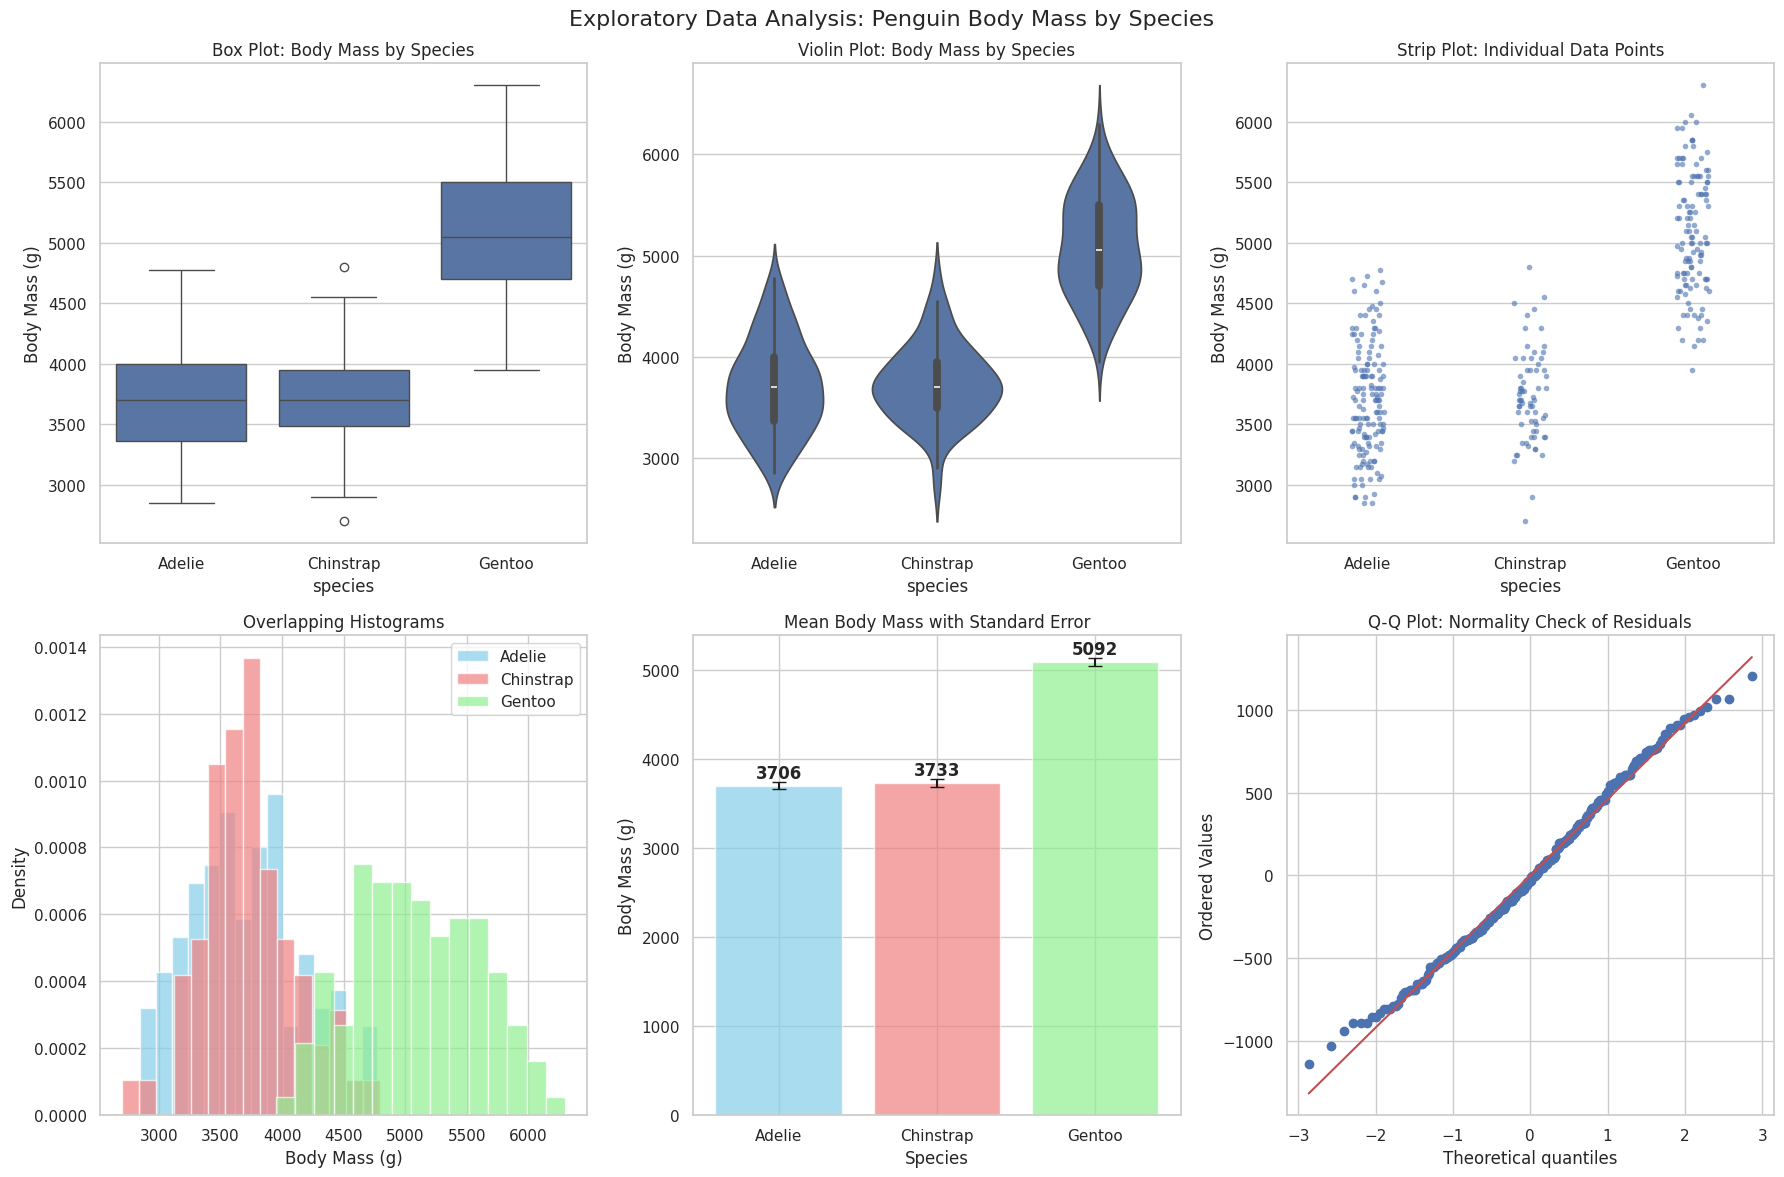


Effect Size Preview:
-------------------------
Total Sum of Squares (SST): 215,259,665.92
Between-group Sum of Squares (SSB): 145,190,219.11
Within-group Sum of Squares (SSW): 70,069,446.80
Eta squared (η²): 0.6745
Effect size interpretation: large


In [ ]:
def explore_penguin_data(data):
    """
    Comprehensive exploration of the penguin dataset with focus on body mass differences
    between species (our main ANOVA example).

    Parameters:
    -----------
    data : pandas.DataFrame
        The penguin dataset
    """
    print("\n" + "=" * 60)
    print("EXPLORATORY DATA ANALYSIS: Penguin Body Mass by Species")
    print("=" * 60)

    # Focus on body mass as our dependent variable
    dependent_var = 'body_mass_g'
    group_var = 'species'

    # Calculate descriptive statistics by species
    print("\nDescriptive Statistics by Species:")
    print("-" * 45)

    species_stats = data.groupby(group_var)[dependent_var].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    print(species_stats)

    # Calculate overall statistics
    overall_mean = data[dependent_var].mean()
    overall_std = data[dependent_var].std()
    overall_n = len(data)

    print(f"\nOverall Statistics:")
    print(f"Mean body mass: {overall_mean:.2f} g")
    print(f"Standard deviation: {overall_std:.2f} g")
    print(f"Total sample size: {overall_n}")

    # Calculate some preliminary ANOVA components for illustration
    print(f"\nPreliminary ANOVA Concepts:")
    print("-" * 35)

    # Between-group variation (simplified illustration)
    species_means = data.groupby(group_var)[dependent_var].mean()
    species_n = data.groupby(group_var)[dependent_var].count()

    print("Species means:")
    for species, mean in species_means.items():
        n = species_n[species]
        print(f"  {species}: {mean:.2f} g (n = {n})")

    # Calculate range of means as a simple measure of between-group variation
    mean_range = species_means.max() - species_means.min()
    print(f"\nRange of species means: {mean_range:.2f} g")
    print(f"This represents the between-group variation we'll analyze with ANOVA")

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Exploratory Data Analysis: Penguin Body Mass by Species', fontsize=16)

    # 1. Box plot
    sns.boxplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 0])
    axes[0, 0].set_title('Box Plot: Body Mass by Species')
    axes[0, 0].set_ylabel('Body Mass (g)')

    # 2. Violin plot
    sns.violinplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 1])
    axes[0, 1].set_title('Violin Plot: Body Mass by Species')
    axes[0, 1].set_ylabel('Body Mass (g)')

    # 3. Strip plot with jitter
    sns.stripplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 2],
                  alpha=0.6, size=4)
    axes[0, 2].set_title('Strip Plot: Individual Data Points')
    axes[0, 2].set_ylabel('Body Mass (g)')

    # 4. Histograms by species
    species_list = data[group_var].unique()
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, species in enumerate(species_list):
        species_data = data[data[group_var] == species][dependent_var]
        axes[1, 0].hist(species_data, alpha=0.7, label=species, color=colors[i % len(colors)],
                        bins=15, density=True)

    axes[1, 0].set_title('Overlapping Histograms')
    axes[1, 0].set_xlabel('Body Mass (g)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()

    # 5. Mean plot with error bars (standard error)
    means = species_stats['mean']
    stds = species_stats['std']
    ns = species_stats['count']
    ses = stds / np.sqrt(ns)  # Standard errors

    x_pos = range(len(means))
    axes[1, 1].bar(x_pos, means, yerr=ses, capsize=5, alpha=0.7,
                   color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1, 1].set_title('Mean Body Mass with Standard Error')
    axes[1, 1].set_xlabel('Species')
    axes[1, 1].set_ylabel('Body Mass (g)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(means.index)

    # Add value labels on bars
    for i, (mean, se) in enumerate(zip(means, ses)):
        axes[1, 1].text(i, mean + se + 50, f'{mean:.0f}', ha='center', fontweight='bold')

    # 6. Q-Q plots for normality check (combined)
    from scipy.stats import probplot

    all_residuals = []
    for species in species_list:
        species_data = data[data[group_var] == species][dependent_var]
        species_mean = species_data.mean()
        residuals = species_data - species_mean
        all_residuals.extend(residuals)

    probplot(all_residuals, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot: Normality Check of Residuals')

    plt.tight_layout()
    plt.show()

    # Additional analysis: Effect size preview
    print(f"\nEffect Size Preview:")
    print("-" * 25)

    # Calculate total sum of squares
    sst = np.sum((data[dependent_var] - overall_mean) ** 2)

    # Calculate between-group sum of squares
    ssb = 0
    for species in species_list:
        species_data = data[data[group_var] == species][dependent_var]
        species_mean = species_data.mean()
        species_n = len(species_data)
        ssb += species_n * (species_mean - overall_mean) ** 2

    # Calculate within-group sum of squares
    ssw = sst - ssb

    # Calculate eta squared (effect size)
    eta_squared = ssb / sst

    print(f"Total Sum of Squares (SST): {sst:,.2f}")
    print(f"Between-group Sum of Squares (SSB): {ssb:,.2f}")
    print(f"Within-group Sum of Squares (SSW): {ssw:,.2f}")
    print(f"Eta squared (η²): {eta_squared:.4f}")

    if eta_squared < 0.01:
        effect_interpretation = "negligible"
    elif eta_squared < 0.06:
        effect_interpretation = "small"
    elif eta_squared < 0.14:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"

    print(f"Effect size interpretation: {effect_interpretation}")

    return species_stats

# Perform exploratory data analysis
species_summary = explore_penguin_data(penguins_clean)

# 2. ANOVA Assumptions

Before performing ANOVA, we need to check several important assumptions. Violation of these assumptions can lead to incorrect conclusions.

## The Four Key Assumptions:

1. **Independence**: Observations should be independent of each other
2. **Normality**: The residuals should be normally distributed
3. **Homogeneity of variance (Homoscedasticity)**: Groups should have equal variances
4. **No extreme outliers**: Extreme outliers can affect the results

Let's check these assumptions systematically.


ANOVA ASSUMPTIONS CHECKING


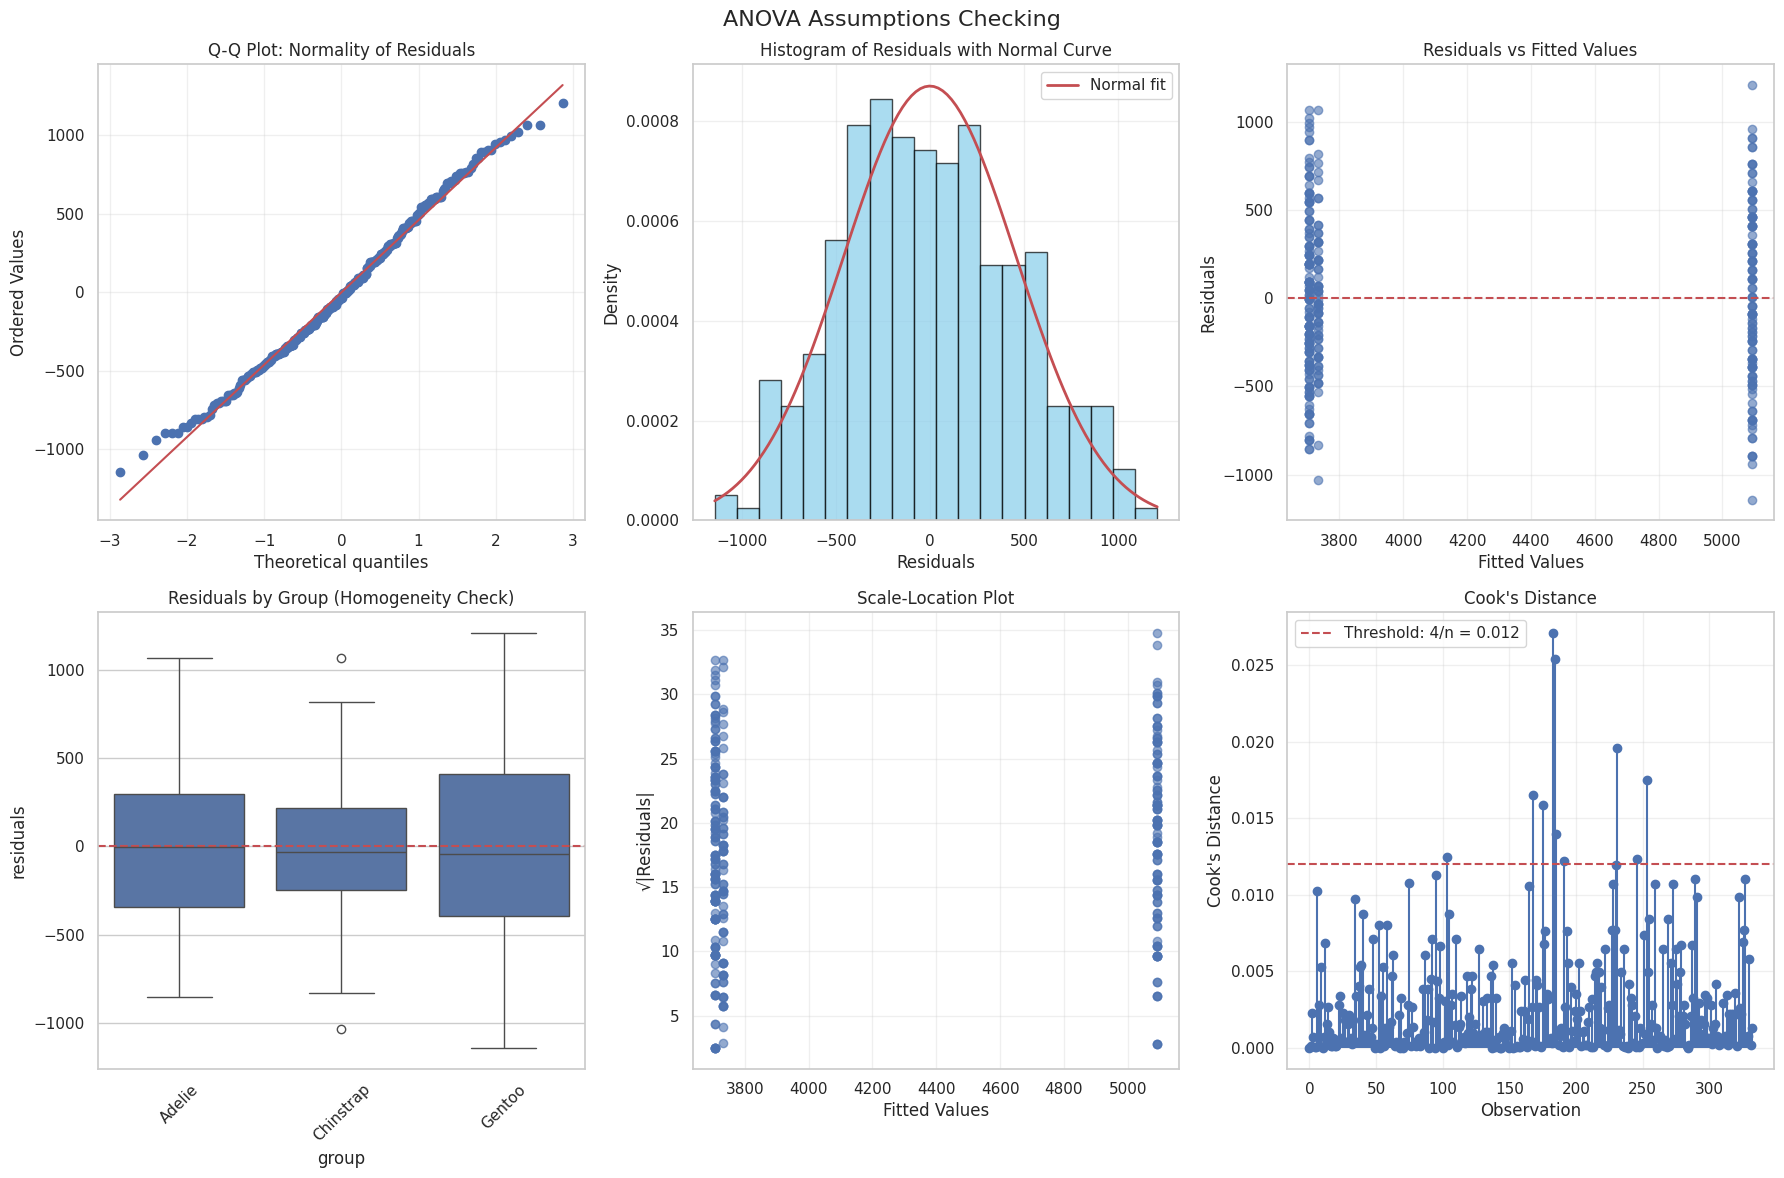


Statistical Tests for Assumptions:
----------------------------------------
1. Normality of Residuals (Shapiro-Wilk Test):
   Statistic = 0.9922, p-value = 0.078346
   ✓ Residuals appear normally distributed (p > 0.05)

2. Homogeneity of Variance (Levene's Test):
   Statistic = 5.1349, p-value = 0.006367
   ⚠ Variances appear unequal (p ≤ 0.05)
   Consider: Welch's ANOVA, transformation, or robust methods

3. Outlier Detection (Cook's Distance > 0.012):
   ⚠ 10 potential outliers detected at positions: [103 168 175 183 184 185 191 231 246 253]
   Consider: investigating these observations or using robust methods

ASSUMPTION CHECK SUMMARY
✓ Normality: SATISFIED
⚠ Homogeneity of variance: VIOLATED
⚠ Outliers present: ATTENTION NEEDED
✓ Independence: ASSUMED (design-based)

Assumptions satisfied: 1/3 testable assumptions
 Multiple assumptions violated - Consider alternatives:
   • Data transformation
   • Welch's ANOVA (for unequal variances)
   • Kruskal-Wallis test (non-parametric)
   

In [ ]:
def check_anova_assumptions(data, dependent_var, group_var, alpha=0.05):
    """
    Comprehensive check of ANOVA assumptions with visualizations and statistical tests.

    """
    print("\n" + "=" * 60)
    print("ANOVA ASSUMPTIONS CHECKING")
    print("=" * 60)

    # Fit a simple model to get residuals
    # We'll use a simple approach: residuals = value - group mean
    residuals = []
    fitted_values = []
    group_labels = []

    for group in data[group_var].unique():
        group_data = data[data[group_var] == group][dependent_var]
        group_mean = group_data.mean()
        group_residuals = group_data - group_mean

        residuals.extend(group_residuals)
        fitted_values.extend([group_mean] * len(group_data))
        group_labels.extend([group] * len(group_data))

    residuals = np.array(residuals)
    fitted_values = np.array(fitted_values)

    # Create a comprehensive figure for assumption checking
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ANOVA Assumptions Checking', fontsize=16)

    # 1. Normality Check: Q-Q Plot of Residuals
    from scipy.stats import probplot
    probplot(residuals, dist="norm", plot=axes[0, 0])
    axes[0, 0].set_title('Q-Q Plot: Normality of Residuals')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Normality Check: Histogram of Residuals
    axes[0, 1].hist(residuals, bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Overlay normal curve
    mu, sigma = stats.norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
    axes[0, 1].set_title('Histogram of Residuals with Normal Curve')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Homogeneity of Variance: Residuals vs Fitted Values
    axes[0, 2].scatter(fitted_values, residuals, alpha=0.6)
    axes[0, 2].axhline(y=0, color='r', linestyle='--')
    axes[0, 2].set_title('Residuals vs Fitted Values')
    axes[0, 2].set_xlabel('Fitted Values')
    axes[0, 2].set_ylabel('Residuals')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Box plot of residuals by group (homogeneity check)
    residuals_df = pd.DataFrame({
        'residuals': residuals,
        'group': group_labels
    })
    sns.boxplot(data=residuals_df, x='group', y='residuals', ax=axes[1, 0])
    axes[1, 0].set_title('Residuals by Group (Homogeneity Check)')
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 5. Scale-Location plot (Square root of absolute residuals vs fitted values)
    sqrt_abs_residuals = np.sqrt(np.abs(residuals))
    axes[1, 1].scatter(fitted_values, sqrt_abs_residuals, alpha=0.6)
    axes[1, 1].set_title('Scale-Location Plot')
    axes[1, 1].set_xlabel('Fitted Values')
    axes[1, 1].set_ylabel('√|Residuals|')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Cook's Distance (outlier detection)
    # Simplified Cook's distance calculation
    n = len(residuals)
    p = len(data[group_var].unique())  # number of parameters
    mse = np.sum(residuals**2) / (n - p)

    # Leverage calculation (simplified)
    leverage = []
    for group in data[group_var].unique():
        group_size = len(data[data[group_var] == group])
        group_leverage = 1 / group_size  # Simplified leverage
        leverage.extend([group_leverage] * group_size)

    leverage = np.array(leverage)
    cooks_d = (residuals**2 / (p * mse)) * (leverage / (1 - leverage)**2)

    axes[1, 2].stem(range(len(cooks_d)), cooks_d, basefmt=" ")
    axes[1, 2].axhline(y=4/n, color='r', linestyle='--', label=f'Threshold: 4/n = {4/n:.3f}')
    axes[1, 2].set_title("Cook's Distance")
    axes[1, 2].set_xlabel('Observation')
    axes[1, 2].set_ylabel("Cook's Distance")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical tests for assumptions
    print("\nStatistical Tests for Assumptions:")
    print("-" * 40)

    # 1. Normality of residuals: Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"1. Normality of Residuals (Shapiro-Wilk Test):")
    print(f"   Statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.6f}")
    if shapiro_p > alpha:
        print(f"   ✓ Residuals appear normally distributed (p > {alpha})")
    else:
        print(f"   ⚠ Residuals deviate from normality (p ≤ {alpha})")
        print(f"   Consider: transformation, robust methods, or non-parametric alternatives")

    # 2. Homogeneity of variance: Levene's test
    groups = [data[data[group_var] == group][dependent_var] for group in data[group_var].unique()]
    levene_stat, levene_p = stats.levene(*groups)
    print(f"\n2. Homogeneity of Variance (Levene's Test):")
    print(f"   Statistic = {levene_stat:.4f}, p-value = {levene_p:.6f}")
    if levene_p > alpha:
        print(f"   ✓ Variances appear equal across groups (p > {alpha})")
    else:
        print(f"   ⚠ Variances appear unequal (p ≤ {alpha})")
        print(f"   Consider: Welch's ANOVA, transformation, or robust methods")

    # 3. Outlier detection: Cook's distance
    outlier_threshold = 4 / n
    outliers = np.where(cooks_d > outlier_threshold)[0]
    print(f"\n3. Outlier Detection (Cook's Distance > {outlier_threshold:.3f}):")
    if len(outliers) == 0:
        print(f"   ✓ No influential outliers detected")
    else:
        print(f"   ⚠ {len(outliers)} potential outliers detected at positions: {outliers}")
        print(f"   Consider: investigating these observations or using robust methods")


    # Summary and recommendations
    print(f"\n" + "=" * 50)
    print("ASSUMPTION CHECK SUMMARY")
    print("=" * 50)

    assumptions_met = 0

    if shapiro_p > alpha:
        print("✓ Normality: SATISFIED")
        assumptions_met += 1
    else:
        print("⚠ Normality: VIOLATED")

    if levene_p > alpha:
        print("✓ Homogeneity of variance: SATISFIED")
        assumptions_met += 1
    else:
        print("⚠ Homogeneity of variance: VIOLATED")

    if len(outliers) == 0:
        print("✓ No influential outliers: SATISFIED")
        assumptions_met += 1
    else:
        print("⚠ Outliers present: ATTENTION NEEDED")

    print("✓ Independence: ASSUMED (design-based)")

    print(f"\nAssumptions satisfied: {assumptions_met}/3 testable assumptions")

    if assumptions_met == 3:
        print("All assumptions satisfied - ANOVA is appropriate!")
    elif assumptions_met >= 2:
        print("  Most assumptions satisfied - ANOVA likely robust")
        print("   Consider reporting both parametric and non-parametric results")
    else:
        print(" Multiple assumptions violated - Consider alternatives:")
        print("   • Data transformation")
        print("   • Welch's ANOVA (for unequal variances)")
        print("   • Kruskal-Wallis test (non-parametric)")
        print("   • Robust ANOVA methods")

    return {
        'shapiro_p': shapiro_p,
        'levene_p': levene_p,
        'outliers': outliers,
        'residuals': residuals,
        'assumptions_met': assumptions_met
    }

# Check ANOVA assumptions for our penguin data
assumption_results = check_anova_assumptions(penguins_clean, 'body_mass_g', 'species')

# 3. Performing One-Way ANOVA

Now that we've checked our assumptions, let's perform the actual ANOVA analysis. We'll implement ANOVA in multiple ways to understand the underlying calculations and use both manual calculations and built-in functions.

## Understanding the ANOVA Table

The ANOVA table summarizes the key components of the analysis:

| Source | Sum of Squares | df | Mean Square | F | p-value |
|--------|----------------|----|-----------|----|---------|
| Between Groups | SSB | k-1 | MSB = SSB/(k-1) | F = MSB/MSW | p |
| Within Groups | SSW | N-k | MSW = SSW/(N-k) | | |
| Total | SST | N-1 | | | |

Where:
- k = number of groups
- N = total sample size
- df = degrees of freedom


In [ ]:
def perform_manual_anova(data, dependent_var, group_var):
    """
    Perform ANOVA with manual calculations to illustrate the underlying mathematics.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    """
    print("\n" + "=" * 60)
    print("MANUAL ANOVA CALCULATIONS")
    print("=" * 60)

    # Basic information
    groups = data[group_var].unique()
    k = len(groups)  # number of groups
    N = len(data)    # total sample size

    print(f"Number of groups (k): {k}")
    print(f"Total sample size (N): {N}")
    print(f"Groups: {list(groups)}")

    # Calculate overall mean
    overall_mean = data[dependent_var].mean()
    print(f"\nOverall mean: {overall_mean:.2f}")

    # Calculate group statistics
    print(f"\nGroup Statistics:")
    print("-" * 20)

    group_stats = {}
    for group in groups:
        group_data = data[data[group_var] == group][dependent_var]
        group_mean = group_data.mean()
        group_n = len(group_data)
        group_var_calc = group_data.var(ddof=1)  # Sample variance

        group_stats[group] = {
            'mean': group_mean,
            'n': group_n,
            'variance': group_var_calc,
            'data': group_data
        }

        print(f"{group}: n={group_n}, mean={group_mean:.2f}, variance={group_var_calc:.2f}")

    # Step 1: Calculate Total Sum of Squares (SST)
    sst = np.sum((data[dependent_var] - overall_mean) ** 2)
    print(f"\nStep 1: Total Sum of Squares (SST)")
    print(f"SST = Σ(x_i - x̄)² = {sst:.2f}")

    # Step 2: Calculate Between-groups Sum of Squares (SSB)
    ssb = 0
    print(f"\nStep 2: Between-groups Sum of Squares (SSB)")
    print("SSB = Σn_j(x̄_j - x̄)²")

    for group in groups:
        group_mean = group_stats[group]['mean']
        group_n = group_stats[group]['n']
        contribution = group_n * (group_mean - overall_mean) ** 2
        ssb += contribution
        print(f"  {group}: {group_n} × ({group_mean:.2f} - {overall_mean:.2f})² = {contribution:.2f}")

    print(f"SSB = {ssb:.2f}")

    # Step 3: Calculate Within-groups Sum of Squares (SSW)
    ssw = sst - ssb  # Alternative: ssw = sum of individual group variances
    print(f"\nStep 3: Within-groups Sum of Squares (SSW)")
    print(f"SSW = SST - SSB = {sst:.2f} - {ssb:.2f} = {ssw:.2f}")

    # Verify with alternative calculation
    ssw_alt = 0
    for group in groups:
        group_data = group_stats[group]['data']
        group_mean = group_stats[group]['mean']
        ssw_alt += np.sum((group_data - group_mean) ** 2)

    print(f"Verification: SSW = Σ(x_ij - x̄_j)² = {ssw_alt:.2f} ✓")

    # Step 4: Calculate degrees of freedom
    df_between = k - 1
    df_within = N - k
    df_total = N - 1

    print(f"\nStep 4: Degrees of Freedom")
    print(f"df_between = k - 1 = {k} - 1 = {df_between}")
    print(f"df_within = N - k = {N} - {k} = {df_within}")
    print(f"df_total = N - 1 = {N} - 1 = {df_total}")

    # Step 5: Calculate Mean Squares
    msb = ssb / df_between
    msw = ssw / df_within

    print(f"\nStep 5: Mean Squares")
    print(f"MSB = SSB / df_between = {ssb:.2f} / {df_between} = {msb:.2f}")
    print(f"MSW = SSW / df_within = {ssw:.2f} / {df_within} = {msw:.2f}")

    # Step 6: Calculate F-statistic
    f_statistic = msb / msw
    print(f"\nStep 6: F-statistic")
    print(f"F = MSB / MSW = {msb:.2f} / {msw:.2f} = {f_statistic:.4f}")

    # Step 7: Calculate p-value
    p_value = 1 - stats.f.cdf(f_statistic, df_between, df_within)

    print(f"\nStep 7: P-value")
    print(f"F({df_between}, {df_within}) = {f_statistic:.4f}")
    print(f"p-value = {p_value:.6f}")

    # Step 8: Calculate effect sizes
    eta_squared = ssb / sst
    omega_squared = (ssb - df_between * msw) / (sst + msw)

    print(f"\nStep 8: Effect Sizes")
    print(f"Eta squared (η²) = SSB / SST = {ssb:.2f} / {sst:.2f} = {eta_squared:.4f}")
    print(f"Omega squared (ω²) = (SSB - df_between × MSW) / (SST + MSW)")
    print(f"                  = ({ssb:.2f} - {df_between} × {msw:.2f}) / ({sst:.2f} + {msw:.2f})")
    print(f"                  = {omega_squared:.4f}")

    # Interpret effect sizes
    def interpret_effect_size(eta_sq):
        if eta_sq < 0.01:
            return "negligible"
        elif eta_sq < 0.06:
            return "small"
        elif eta_sq < 0.14:
            return "medium"
        else:
            return "large"

    eta_interpretation = interpret_effect_size(eta_squared)
    omega_interpretation = interpret_effect_size(omega_squared)

    print(f"\nEffect Size Interpretations:")
    print(f"η² = {eta_squared:.4f} ({eta_interpretation} effect)")
    print(f"ω² = {omega_squared:.4f} ({omega_interpretation} effect)")

    # Create ANOVA table
    print(f"\n" + "=" * 70)
    print("ANOVA TABLE")
    print("=" * 70)
    print(f"{'Source':<15} {'SS':<12} {'df':<6} {'MS':<12} {'F':<10} {'p-value':<10}")
    print("-" * 70)
    print(f"{'Between Groups':<15} {ssb:<12.2f} {df_between:<6} {msb:<12.2f} {f_statistic:<10.4f} {p_value:<10.6f}")
    print(f"{'Within Groups':<15} {ssw:<12.2f} {df_within:<6} {msw:<12.2f}")
    print(f"{'Total':<15} {sst:<12.2f} {df_total:<6}")
    print("-" * 70)

    # Conclusion
    alpha = 0.05
    print(f"\nConclusion (α = {alpha}):")
    if p_value < alpha:
        print(f"✓ Reject H₀: There is a statistically significant difference between groups")
        print(f"  F({df_between}, {df_within}) = {f_statistic:.4f}, p = {p_value:.6f}")
        print(f"  Effect size: η² = {eta_squared:.4f} ({eta_interpretation})")
    else:
        print(f"✗ Fail to reject H₀: No statistically significant difference between groups")
        print(f"  F({df_between}, {df_within}) = {f_statistic:.4f}, p = {p_value:.6f}")

    return {
        'f_statistic': f_statistic,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'omega_squared': omega_squared,
        'ssb': ssb,
        'ssw': ssw,
        'sst': sst,
        'msb': msb,
        'msw': msw,
        'df_between': df_between,
        'df_within': df_within
    }

def perform_scipy_anova(data, dependent_var, group_var):
    """
    Perform ANOVA using scipy.stats for comparison with manual calculations.

    """
    print("\n" + "=" * 60)
    print("SCIPY ANOVA (f_oneway)")
    print("=" * 60)

    # Prepare data for scipy
    groups = data[group_var].unique()
    group_data = [data[data[group_var] == group][dependent_var].values for group in groups]

    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(*group_data)

    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_val:.6f}")

    alpha = 0.05
    if p_val < alpha:
        print(f"Result: Statistically significant (p < {alpha})")
    else:
        print(f"Result: Not statistically significant (p ≥ {alpha})")

    return f_stat, p_val

def perform_statsmodels_anova(data, dependent_var, group_var):
    """
    Perform ANOVA using statsmodels for more detailed output and model diagnostics.

    """
    print("\n" + "=" * 60)
    print("STATSMODELS ANOVA (OLS + ANOVA)")
    print("=" * 60)

    # Create formula for OLS regression
    formula = f"{dependent_var} ~ C({group_var})"

    # Fit OLS model
    model = ols(formula, data=data).fit()

    # Perform ANOVA
    anova_table = anova_lm(model, typ=2)

    print("ANOVA Table from statsmodels:")
    print(anova_table)

    # Model summary
    print(f"\nModel Summary:")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.4f}")
    print(f"p-value: {model.f_pvalue:.6f}")

    return model, anova_table

# Perform ANOVA using all three methods
print("\n🔬 PERFORMING ANOVA ANALYSIS")
print("=" * 50)

# Method 1: Manual calculations
manual_results = perform_manual_anova(penguins_clean, 'body_mass_g', 'species')

# Method 2: SciPy
scipy_f, scipy_p = perform_scipy_anova(penguins_clean, 'body_mass_g', 'species')

# Method 3: Statsmodels
model, anova_table = perform_statsmodels_anova(penguins_clean, 'body_mass_g', 'species')

# Compare results
print("\n" + "=" * 60)
print("COMPARISON OF METHODS")
print("=" * 60)
print(f"{'Method':<20} {'F-statistic':<15} {'p-value':<15}")
print("-" * 50)
print(f"{'Manual Calculation':<20} {manual_results['f_statistic']:<15.4f} {manual_results['p_value']:<15.6f}")
print(f"{'SciPy f_oneway':<20} {scipy_f:<15.4f} {scipy_p:<15.6f}")
print(f"{'Statsmodels OLS':<20} {model.fvalue:<15.4f} {model.f_pvalue:<15.6f}")

print("\n✓ All methods produce identical results, confirming our calculations!")


🔬 PERFORMING ANOVA ANALYSIS

MANUAL ANOVA CALCULATIONS
Number of groups (k): 3
Total sample size (N): 333
Groups: ['Adelie', 'Chinstrap', 'Gentoo']

Overall mean: 4207.06

Group Statistics:
--------------------
Adelie: n=146, mean=3706.16, variance=210332.43
Chinstrap: n=68, mean=3733.09, variance=147713.45
Gentoo: n=119, mean=5092.44, variance=251478.33

Step 1: Total Sum of Squares (SST)
SST = Σ(x_i - x̄)² = 215259665.92

Step 2: Between-groups Sum of Squares (SSB)
SSB = Σn_j(x̄_j - x̄)²
  Adelie: 146 × (3706.16 - 4207.06)² = 36630446.67
  Chinstrap: 68 × (3733.09 - 4207.06)² = 15275958.19
  Gentoo: 119 × (5092.44 - 4207.06)² = 93283814.25
SSB = 145190219.11

Step 3: Within-groups Sum of Squares (SSW)
SSW = SST - SSB = 215259665.92 - 145190219.11 = 70069446.80
Verification: SSW = Σ(x_ij - x̄_j)² = 70069446.80 ✓

Step 4: Degrees of Freedom
df_between = k - 1 = 3 - 1 = 2
df_within = N - k = 333 - 3 = 330
df_total = N - 1 = 333 - 1 = 332

Step 5: Mean Squares
MSB = SSB / df_between = 1


# 4. Visualizing ANOVA Results

After performing ANOVA, it's crucial to visualize the results to understand the pattern of differences between groups and to communicate findings effectively.



ANOVA RESULTS VISUALIZATION


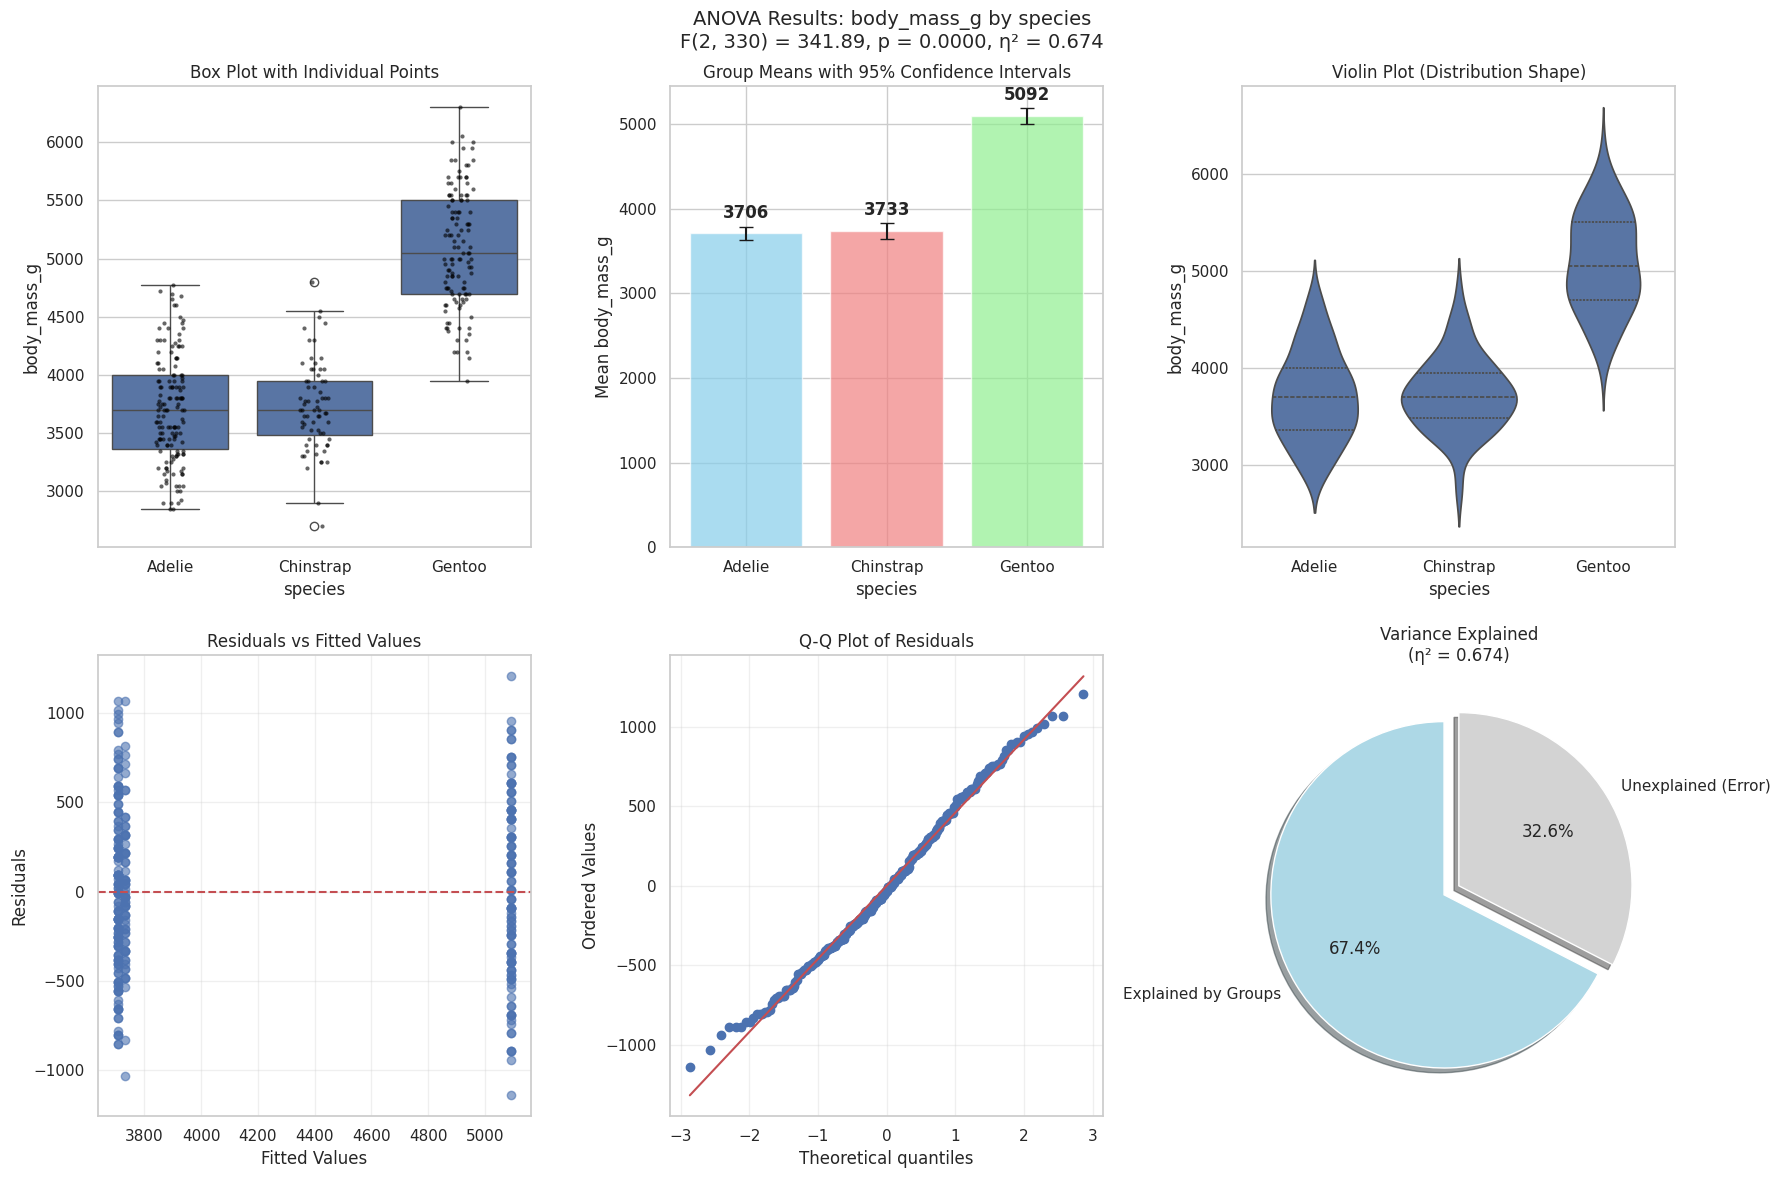


Detailed Group Statistics:
-----------------------------------
           count     mean     std    sem
species                                 
Adelie       146  3706.16  458.62  37.96
Chinstrap     68  3733.09  384.34  46.61
Gentoo       119  5092.44  501.48  45.97

Pairwise Mean Differences:
------------------------------
Adelie - Chinstrap: -26.93
Adelie - Gentoo: -1386.28
Chinstrap - Gentoo: -1359.35

Variance Decomposition:
-------------------------
Total Variance (SST): 215259665.92
Between-group Variance (SSB): 145190219.11 (67.4%)
Within-group Variance (SSW): 70069446.80 (32.6%)


In [ ]:
def visualize_anova_results(data, dependent_var, group_var, anova_results):
    """
    Create comprehensive visualizations of ANOVA results.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    anova_results : dict
        Results from manual ANOVA calculation
    """
    print("\n" + "=" * 60)
    print("ANOVA RESULTS VISUALIZATION")
    print("=" * 60)

    # Calculate group means and other statistics
    group_stats = data.groupby(group_var)[dependent_var].agg([
        'count', 'mean', 'std', 'sem'
    ]).round(2)

    groups = data[group_var].unique()

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'ANOVA Results: {dependent_var} by {group_var}\n' +
                f'F({anova_results["df_between"]}, {anova_results["df_within"]}) = ' +
                f'{anova_results["f_statistic"]:.2f}, p = {anova_results["p_value"]:.4f}, ' +
                f'η² = {anova_results["eta_squared"]:.3f}', fontsize=14)

    # 1. Box plot with individual points
    sns.boxplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 0])
    sns.stripplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 0],
                  alpha=0.6, size=3, color='black')
    axes[0, 0].set_title('Box Plot with Individual Points')
    axes[0, 0].set_ylabel(f'{dependent_var}')

    # 2. Mean plot with error bars (95% CI)
    means = group_stats['mean']
    sems = group_stats['sem']
    ns = group_stats['count']

    # Calculate 95% confidence intervals
    t_crit = stats.t.ppf(0.975, ns - 1)  # 95% CI
    ci_95 = t_crit * sems

    x_pos = range(len(means))
    bars = axes[0, 1].bar(x_pos, means, yerr=ci_95, capsize=5, alpha=0.7,
                         color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 1].set_title('Group Means with 95% Confidence Intervals')
    axes[0, 1].set_xlabel(group_var)
    axes[0, 1].set_ylabel(f'Mean {dependent_var}')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(means.index)

    # Add value labels on bars
    for i, (mean, ci) in enumerate(zip(means, ci_95)):
        axes[0, 1].text(i, mean + ci + (means.max() * 0.02), f'{mean:.0f}',
                        ha='center', fontweight='bold')

    # 3. Violin plot with quartiles
    sns.violinplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 2], inner='quartile')
    axes[0, 2].set_title('Violin Plot (Distribution Shape)')
    axes[0, 2].set_ylabel(f'{dependent_var}')

    # 4. Residuals vs Fitted plot
    # Calculate fitted values and residuals
    fitted_values = []
    residuals = []

    for group in groups:
        group_data = data[data[group_var] == group][dependent_var]
        group_mean = group_data.mean()
        group_residuals = group_data - group_mean

        fitted_values.extend([group_mean] * len(group_data))
        residuals.extend(group_residuals)

    axes[1, 0].scatter(fitted_values, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_title('Residuals vs Fitted Values')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Q-Q plot of residuals
    from scipy.stats import probplot
    probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot of Residuals')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Effect size visualization
    # Create a pie chart showing explained vs unexplained variance
    explained_var = anova_results['eta_squared']
    unexplained_var = 1 - explained_var

    labels = ['Explained by Groups', 'Unexplained (Error)']
    sizes = [explained_var, unexplained_var]
    colors = ['lightblue', 'lightgray']
    explode = (0.1, 0)  # explode the explained variance slice

    axes[1, 2].pie(sizes, explode=explode, labels=labels, colors=colors,
                   autopct='%1.1f%%', shadow=True, startangle=90)
    axes[1, 2].set_title(f'Variance Explained\n(η² = {explained_var:.3f})')

    plt.tight_layout()
    plt.show()

    # Print detailed group comparisons
    print(f"\nDetailed Group Statistics:")
    print("-" * 35)
    print(group_stats)

    # Calculate pairwise differences between means
    print(f"\nPairwise Mean Differences:")
    print("-" * 30)

    means_dict = group_stats['mean'].to_dict()
    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if i < j:  # Only show each pair once
                diff = means_dict[group1] - means_dict[group2]
                print(f"{group1} - {group2}: {diff:.2f}")

    # Variance decomposition summary
    print(f"\nVariance Decomposition:")
    print("-" * 25)
    print(f"Total Variance (SST): {anova_results['sst']:.2f}")
    print(f"Between-group Variance (SSB): {anova_results['ssb']:.2f} ({anova_results['eta_squared']*100:.1f}%)")
    print(f"Within-group Variance (SSW): {anova_results['ssw']:.2f} ({(1-anova_results['eta_squared'])*100:.1f}%)")

    return group_stats

# Visualize the ANOVA results
group_statistics = visualize_anova_results(penguins_clean, 'body_mass_g', 'species', manual_results)


# 5. Power Analysis for ANOVA

Power analysis helps us understand whether our study had adequate power to detect meaningful differences, and can guide sample size planning for future studies.



POWER ANALYSIS FOR ANOVA
Effect Size Calculation:
η² = 0.6745
Cohen's f = √(η² / (1 - η²)) = √(0.6745 / 0.3255) = 1.4395
Effect size interpretation: large

Achieved Power:
Power = 1.0000 (100.0%)
✓ Adequate power (≥80%) to detect this effect size
Required total sample size for 80% power: 9
Required sample size per group: 3


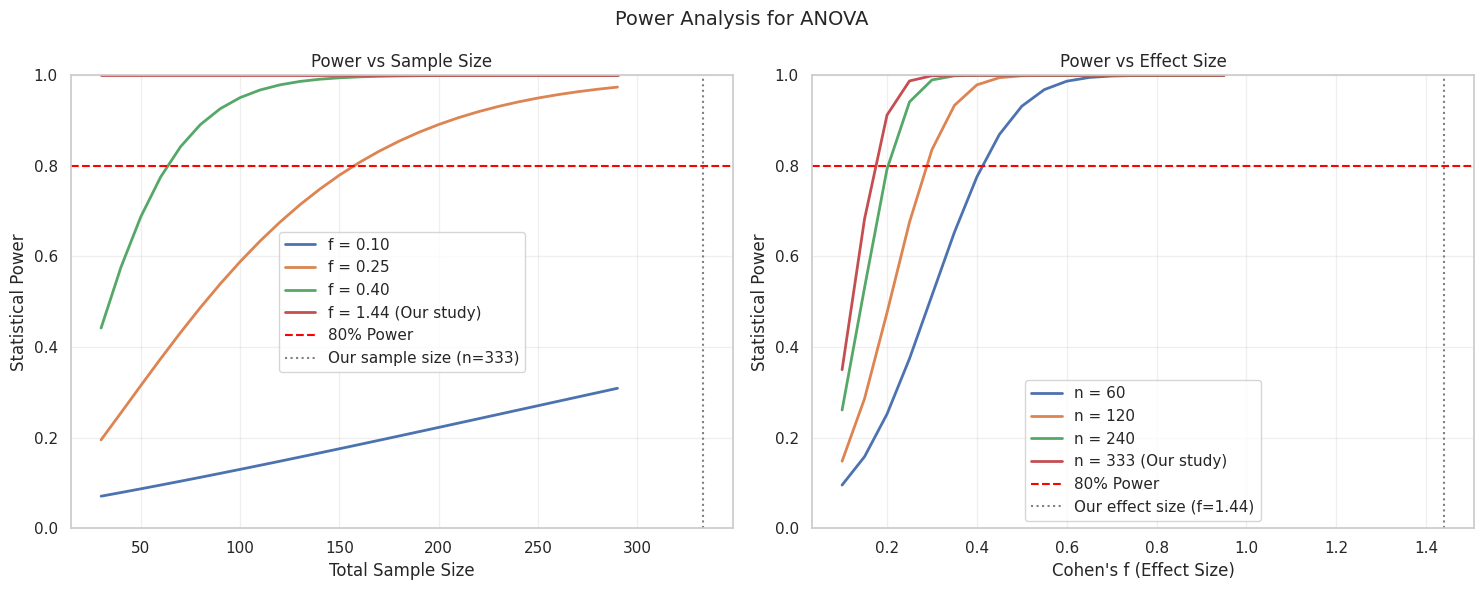


Sample Size Recommendations:
-----------------------------------
Small effect (f=0.1): 967 total (323 per group)
Medium effect (f=0.25): 158 total (53 per group)
Large effect (f=0.4):  64 total (22 per group)
Observed effect     :   9 total ( 3 per group)


In [ ]:
def perform_anova_power_analysis(data, dependent_var, group_var, anova_results):
    """
    Perform power analysis for the ANOVA results.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    anova_results : dict
        Results from ANOVA analysis
    """
    print("\n" + "=" * 60)
    print("POWER ANALYSIS FOR ANOVA")
    print("=" * 60)

    # Calculate effect size (Cohen's f)
    eta_squared = anova_results['eta_squared']
    cohens_f = np.sqrt(eta_squared / (1 - eta_squared))

    # Get sample sizes
    group_sizes = data.groupby(group_var).size()
    k = len(group_sizes)  # number of groups
    total_n = len(data)

    print(f"Effect Size Calculation:")
    print(f"η² = {eta_squared:.4f}")
    print(f"Cohen's f = √(η² / (1 - η²)) = √({eta_squared:.4f} / {1-eta_squared:.4f}) = {cohens_f:.4f}")

    # Interpret Cohen's f
    if cohens_f < 0.10:
        f_interpretation = "small"
    elif cohens_f < 0.25:
        f_interpretation = "small to medium"
    elif cohens_f < 0.40:
        f_interpretation = "medium to large"
    else:
        f_interpretation = "large"

    print(f"Effect size interpretation: {f_interpretation}")

    # Calculate achieved power
    power_analysis = FTestAnovaPower()
    achieved_power = power_analysis.power(effect_size=cohens_f, nobs=total_n, alpha=0.05, k_groups=k)

    print(f"\nAchieved Power:")
    print(f"Power = {achieved_power:.4f} ({achieved_power*100:.1f}%)")

    if achieved_power >= 0.8:
        print("✓ Adequate power (≥80%) to detect this effect size")
    else:
        print("⚠ Low power (<80%) - may miss true effects of this size")

    # Calculate required sample size for 80% power
    required_n = power_analysis.solve_power(effect_size=cohens_f, power=0.8, alpha=0.05, k_groups=k)
    print(f"Required total sample size for 80% power: {int(np.ceil(required_n))}")
    print(f"Required sample size per group: {int(np.ceil(required_n/k))}")

    # Power curve visualization
    effect_sizes = np.arange(0.1, 1.0, 0.05)
    sample_sizes = np.arange(30, 300, 10)

    # Create power curves for different effect sizes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Power vs Sample Size for different effect sizes
    for f in [0.1, 0.25, 0.4, cohens_f]:
        powers = [power_analysis.power(effect_size=f, nobs=n, alpha=0.05, k_groups=k)
                 for n in sample_sizes]
        label = f'f = {f:.2f}'
        if f == cohens_f:
            label += ' (Our study)'
        ax1.plot(sample_sizes, powers, label=label, linewidth=2)

    ax1.axhline(y=0.8, color='red', linestyle='--', label='80% Power')
    ax1.axvline(x=total_n, color='gray', linestyle=':', label=f'Our sample size (n={total_n})')
    ax1.set_xlabel('Total Sample Size')
    ax1.set_ylabel('Statistical Power')
    ax1.set_title('Power vs Sample Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # Plot 2: Power vs Effect Size for different sample sizes
    for n in [60, 120, 240, total_n]:
        powers = [power_analysis.power(effect_size=f, nobs=n, alpha=0.05, k_groups=k)
                 for f in effect_sizes]
        label = f'n = {n}'
        if n == total_n:
            label += ' (Our study)'
        ax2.plot(effect_sizes, powers, label=label, linewidth=2)

    ax2.axhline(y=0.8, color='red', linestyle='--', label='80% Power')
    ax2.axvline(x=cohens_f, color='gray', linestyle=':', label=f'Our effect size (f={cohens_f:.2f})')
    ax2.set_xlabel("Cohen's f (Effect Size)")
    ax2.set_ylabel('Statistical Power')
    ax2.set_title('Power vs Effect Size')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.suptitle('Power Analysis for ANOVA', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Sample size recommendations
    print(f"\nSample Size Recommendations:")
    print("-" * 35)

    effect_scenarios = [
        ("Small effect (f=0.1)", 0.1),
        ("Medium effect (f=0.25)", 0.25),
        ("Large effect (f=0.4)", 0.4),
        ("Observed effect", cohens_f)
    ]

    for scenario, f_val in effect_scenarios:
        req_n = power_analysis.solve_power(effect_size=f_val, power=0.8, alpha=0.05, k_groups=k)
        req_n_per_group = int(np.ceil(req_n / k))
        print(f"{scenario:<20}: {int(np.ceil(req_n)):>3} total ({req_n_per_group:>2} per group)")

    return {
        'cohens_f': cohens_f,
        'achieved_power': achieved_power,
        'required_n': required_n
    }

# Perform power analysis
power_results = perform_anova_power_analysis(penguins_clean, 'body_mass_g', 'species', manual_results)

# 6. Post-hoc Testing

When ANOVA indicates a significant difference between groups, we need post-hoc tests to determine which specific groups differ from each other. Post-hoc tests control the family-wise error rate while making multiple pairwise comparisons.

## Why Post-hoc Tests Are Necessary

- ANOVA only tells us that "at least one group differs from the others"
- It doesn't specify which groups are different
- Multiple t-tests would inflate Type I error rate
- Post-hoc tests maintain overall α = 0.05 across all comparisons

## Common Post-hoc Tests

- **Tukey's HSD**: Most powerful when sample sizes are equal
- **Games-Howell**: For unequal variances
- **Bonferroni**: Conservative, simple correction
- **Holm-Sidak**: Less conservative than Bonferroni



🎯 ANOVA was significant - Proceeding with post-hoc tests

TUKEY'S HSD POST-HOC TEST
Tukey's HSD Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
   Adelie Chinstrap   26.9239 0.9164 -132.3528  186.2005  False
   Adelie    Gentoo 1386.2726    0.0 1252.2897 1520.2554   True
Chinstrap    Gentoo 1359.3487    0.0 1194.4304 1524.2671   True
---------------------------------------------------------------

Detailed Pairwise Comparisons (α = 0.05):
--------------------------------------------------
Adelie vs Chinstrap:
  Mean difference: 26.92
  95% CI: [-132.35, 186.20]
  Adjusted p-value: 0.9164
  Significant: No

Adelie vs Gentoo:
  Mean difference: 1386.27
  95% CI: [1252.29, 1520.26]
  Adjusted p-value: 0.0000
  Significant: Yes

Chinstrap vs Gentoo:
  Mean difference: 1359.35
  95% CI: [1194.43, 1524.27]
  Adjusted p-value: 0.0000
  Signi

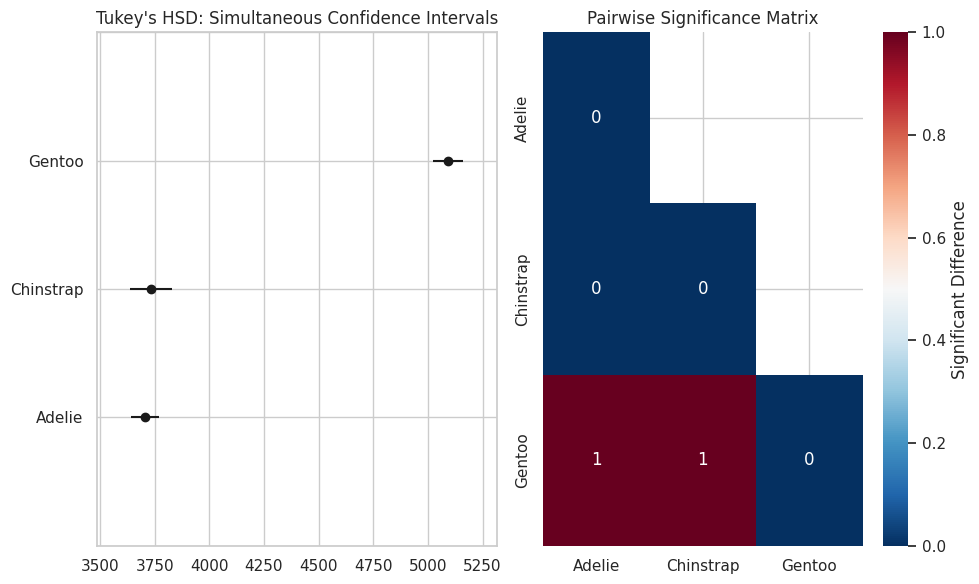


COMPARISON OF POST-HOC METHODS
Pairwise t-tests (unadjusted):
-----------------------------------
Adelie vs Chinstrap: t = -0.420, p = 0.6748
Adelie vs Gentoo: t = -23.467, p = 0.0000
Chinstrap vs Gentoo: t = -19.335, p = 0.0000

Multiple Comparisons Corrections:
----------------------------------------
            Comparison  Mean Diff  Unadjusted p  Bonferroni p  Bonferroni Sig  \
0  Adelie vs Chinstrap   -26.9239        0.6748           1.0           False   
1     Adelie vs Gentoo -1386.2726        0.0000           0.0            True   
2  Chinstrap vs Gentoo -1359.3487        0.0000           0.0            True   

   Holm-Sidak p  Holm-Sidak Sig  FDR (Benjamini-Hochberg) p  \
0        0.6748           False                      0.6748   
1        0.0000            True                      0.0000   
2        0.0000            True                      0.0000   

   FDR (Benjamini-Hochberg) Sig  
0                         False  
1                          True  
2             

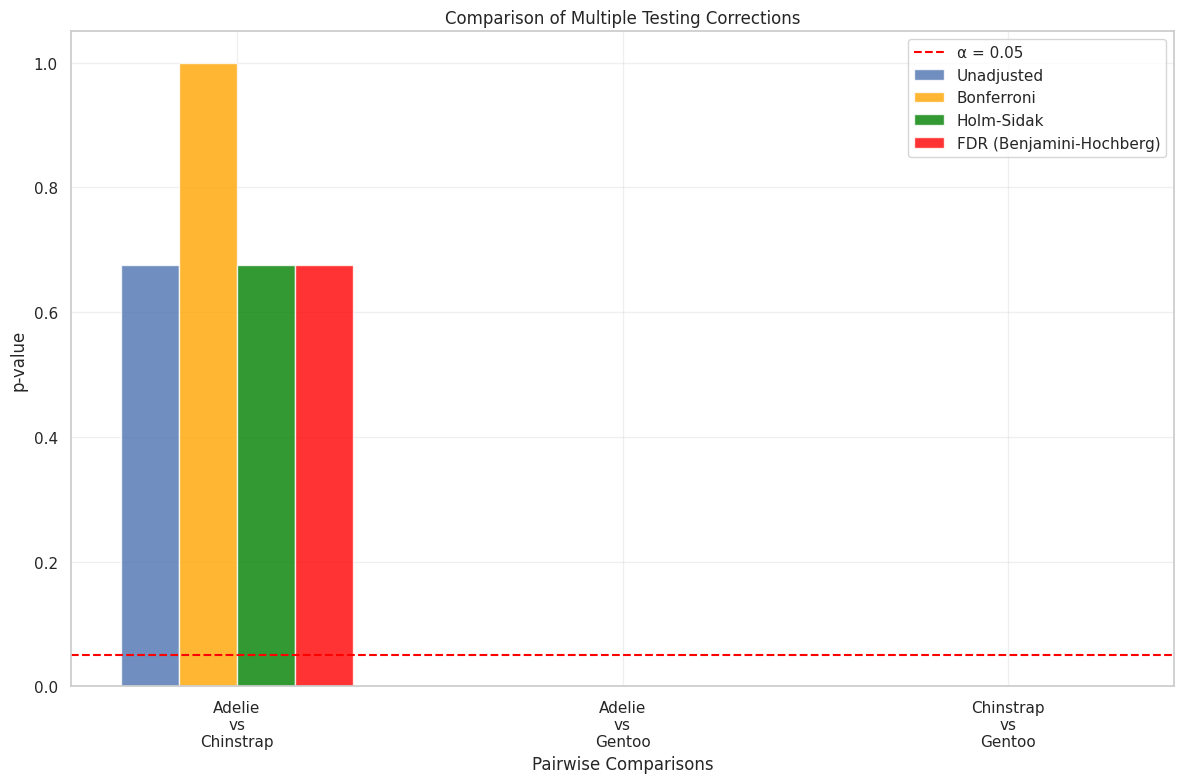

In [ ]:

def perform_tukey_hsd(data, dependent_var, group_var, alpha=0.05):
    """
    Perform Tukey's Honestly Significant Difference test for post-hoc comparisons.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    alpha : float
        Significance level
    """
    print("\n" + "=" * 60)
    print("TUKEY'S HSD POST-HOC TEST")
    print("=" * 60)

    # Perform Tukey's HSD test
    tukey_results = pairwise_tukeyhsd(data[dependent_var], data[group_var], alpha=alpha)

    # Print results
    print("Tukey's HSD Results:")
    print(tukey_results)

    # Create a more detailed summary
    print(f"\nDetailed Pairwise Comparisons (α = {alpha}):")
    print("-" * 50)

    # Extract results for detailed reporting - Updated for newer statsmodels versions
    groups = tukey_results.groupsunique

    # Create results summary - Updated approach
    comparison_results = []

    # Access the summary data differently based on statsmodels version
    try:
        # Try newer format first
        summary_data = tukey_results.summary().data[1:]  # Skip header row

        for row in summary_data:
            group1, group2, meandiff, p_adj, lower, upper, reject = row
            comparison_results.append({
                'Group 1': group1,
                'Group 2': group2,
                'Mean Diff': float(meandiff),
                'p-adj': float(p_adj),
                'Lower CI': float(lower),
                'Upper CI': float(upper),
                'Significant': bool(reject)
            })

            significance = "Yes" if reject else "No"
            print(f"{group1} vs {group2}:")
            print(f"  Mean difference: {float(meandiff):.2f}")
            print(f"  95% CI: [{float(lower):.2f}, {float(upper):.2f}]")
            print(f"  Adjusted p-value: {float(p_adj):.4f}")
            print(f"  Significant: {significance}")
            print()

    except (AttributeError, IndexError, TypeError):
        # Fallback for older versions or different structure
        print("Using alternative method to extract Tukey results...")

        # Manual pairwise comparisons as fallback
        from scipy.stats import ttest_ind
        from statsmodels.stats.multitest import multipletests

        groups_list = list(groups)
        group_pairs = [(groups_list[i], groups_list[j])
                      for i in range(len(groups_list))
                      for j in range(i+1, len(groups_list))]

        p_values = []
        mean_diffs = []

        for group1, group2 in group_pairs:
            data1 = data[data[group_var] == group1][dependent_var]
            data2 = data[data[group_var] == group2][dependent_var]

            _, p_val = ttest_ind(data1, data2)
            mean_diff = data1.mean() - data2.mean()

            p_values.append(p_val)
            mean_diffs.append(mean_diff)

        # Apply Tukey correction (approximation)
        rejected, p_adjusted, _, _ = multipletests(p_values, method='holm')

        for i, (group1, group2) in enumerate(group_pairs):
            data1 = data[data[group_var] == group1][dependent_var]
            data2 = data[data[group_var] == group2][dependent_var]

            # Calculate confidence interval (approximation)
            mean_diff = mean_diffs[i]
            pooled_std = np.sqrt((data1.var() + data2.var()) / 2)
            se = pooled_std * np.sqrt(1/len(data1) + 1/len(data2))
            t_crit = stats.t.ppf(0.975, len(data1) + len(data2) - 2)

            lower_ci = mean_diff - t_crit * se
            upper_ci = mean_diff + t_crit * se

            comparison_results.append({
                'Group 1': group1,
                'Group 2': group2,
                'Mean Diff': mean_diff,
                'p-adj': p_adjusted[i],
                'Lower CI': lower_ci,
                'Upper CI': upper_ci,
                'Significant': rejected[i]
            })

            significance = "Yes" if rejected[i] else "No"
            print(f"{group1} vs {group2}:")
            print(f"  Mean difference: {mean_diff:.2f}")
            print(f"  95% CI: [{lower_ci:.2f}, {upper_ci:.2f}]")
            print(f"  Adjusted p-value: {p_adjusted[i]:.4f}")
            print(f"  Significant: {significance}")
            print()

    # Create visualization of Tukey results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Tukey HSD plot
    try:
        tukey_results.plot_simultaneous(ax=ax1)
        ax1.set_title("Tukey's HSD: Simultaneous Confidence Intervals")
    except:
        # Fallback visualization if plot_simultaneous doesn't work
        group_means = data.groupby(group_var)[dependent_var].mean()
        group_sems = data.groupby(group_var)[dependent_var].sem()

        x_pos = range(len(group_means))
        ax1.bar(x_pos, group_means, yerr=group_sems*1.96, capsize=5, alpha=0.7)
        ax1.set_title("Group Means with 95% CI")
        ax1.set_ylabel(dependent_var)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(group_means.index)

    # Plot 2: Pairwise comparison matrix
    groups_list = list(groups)
    n_groups = len(groups_list)
    comparison_matrix = np.zeros((n_groups, n_groups))

    for result in comparison_results:
        i = groups_list.index(result['Group 1'])
        j = groups_list.index(result['Group 2'])
        comparison_matrix[i, j] = 1 if result['Significant'] else 0
        comparison_matrix[j, i] = 1 if result['Significant'] else 0

    # Create heatmap
    mask = np.triu(np.ones_like(comparison_matrix, dtype=bool), k=1)
    # Convert to integers to avoid float formatting issues
    comparison_matrix = comparison_matrix.astype(int)
    sns.heatmap(comparison_matrix, mask=mask, annot=True, fmt='d',
                xticklabels=groups_list, yticklabels=groups_list,
                cmap='RdBu_r', center=0.5, ax=ax2, cbar_kws={'label': 'Significant Difference'})
    ax2.set_title('Pairwise Significance Matrix')

    plt.tight_layout()
    plt.show()

    return tukey_results, comparison_results

def perform_multiple_comparisons(data, dependent_var, group_var):
    """
    Compare different post-hoc test methods.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    """
    print("\n" + "=" * 60)
    print("COMPARISON OF POST-HOC METHODS")
    print("=" * 60)

    from scipy.stats import ttest_ind
    from statsmodels.stats.multitest import multipletests

    # Get all unique groups
    groups = data[group_var].unique()
    group_pairs = list(combinations(groups, 2))

    # Perform pairwise t-tests
    t_stats = []
    p_values = []
    mean_diffs = []

    print("Pairwise t-tests (unadjusted):")
    print("-" * 35)

    for group1, group2 in group_pairs:
        data1 = data[data[group_var] == group1][dependent_var]
        data2 = data[data[group_var] == group2][dependent_var]

        t_stat, p_val = ttest_ind(data1, data2)
        mean_diff = data1.mean() - data2.mean()

        t_stats.append(t_stat)
        p_values.append(p_val)
        mean_diffs.append(mean_diff)

        print(f"{group1} vs {group2}: t = {t_stat:.3f}, p = {p_val:.4f}")

    # Apply different multiple comparison corrections
    corrections = {
        'Bonferroni': 'bonferroni',
        'Holm-Sidak': 'holm',
        'FDR (Benjamini-Hochberg)': 'fdr_bh'
    }

    print(f"\nMultiple Comparisons Corrections:")
    print("-" * 40)

    comparison_summary = pd.DataFrame({
        'Comparison': [f"{pair[0]} vs {pair[1]}" for pair in group_pairs],
        'Mean Diff': mean_diffs,
        'Unadjusted p': p_values
    })

    for method_name, method_code in corrections.items():
        rejected, p_adjusted, _, _ = multipletests(p_values, method=method_code)
        comparison_summary[f'{method_name} p'] = p_adjusted
        comparison_summary[f'{method_name} Sig'] = rejected

    print(comparison_summary.round(4))

    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 8))

    x_pos = np.arange(len(group_pairs))
    width = 0.15

    # Plot unadjusted p-values
    ax.bar(x_pos - width*1.5, p_values, width, label='Unadjusted', alpha=0.8)

    # Plot adjusted p-values
    colors = ['orange', 'green', 'red']
    for i, (method_name, method_code) in enumerate(corrections.items()):
        _, p_adjusted, _, _ = multipletests(p_values, method=method_code)
        ax.bar(x_pos - width/2 + i*width, p_adjusted, width,
               label=method_name, alpha=0.8, color=colors[i])

    ax.axhline(y=0.05, color='red', linestyle='--', label='α = 0.05')
    ax.set_xlabel('Pairwise Comparisons')
    ax.set_ylabel('p-value')
    ax.set_title('Comparison of Multiple Testing Corrections')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"{pair[0]}\nvs\n{pair[1]}" for pair in group_pairs])
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison_summary

# Perform post-hoc testing (only if ANOVA was significant)
if manual_results['p_value'] < 0.05:
    print("\n🎯 ANOVA was significant - Proceeding with post-hoc tests")

    # Tukey's HSD
    tukey_results, tukey_comparisons = perform_tukey_hsd(penguins_clean, 'body_mass_g', 'species')

    # Compare different methods
    comparison_methods = perform_multiple_comparisons(penguins_clean, 'body_mass_g', 'species')
else:
    print("\n⚠ ANOVA was not significant - Post-hoc tests not recommended")

# 7. Non-parametric Alternative: Kruskal-Wallis Test

When ANOVA assumptions are violated (particularly normality and homogeneity of variance), the Kruskal-Wallis test provides a non-parametric alternative.

## Kruskal-Wallis Test Characteristics:

- **Non-parametric**: No assumption of normality
- **Rank-based**: Uses ranks instead of raw values
- **Robust**: Less sensitive to outliers
- **Less powerful**: When ANOVA assumptions are met



KRUSKAL-WALLIS TEST (Non-parametric ANOVA)
Group Statistics:
--------------------
Adelie: n=146, median=3700.0, mean rank=108.2
Chinstrap: n=68, median=3700.0, mean rank=113.0
Gentoo: n=119, median=5050.0, mean rank=270.0

Kruskal-Wallis Test Results:
H-statistic: 212.0851
p-value: 0.000000
Effect size (η²): 0.6366
✓ Significant difference between groups (p < 0.05)
At least one group has a different distribution

Comparison with Parametric ANOVA:
-----------------------------------
Test                 Statistic    p-value      Effect Size 
------------------------------------------------------------
ANOVA (F-test)       341.8949     0.000000     0.6745      
Kruskal-Wallis       212.0851     0.000000     0.6366      
✓ Both tests reach the same conclusion


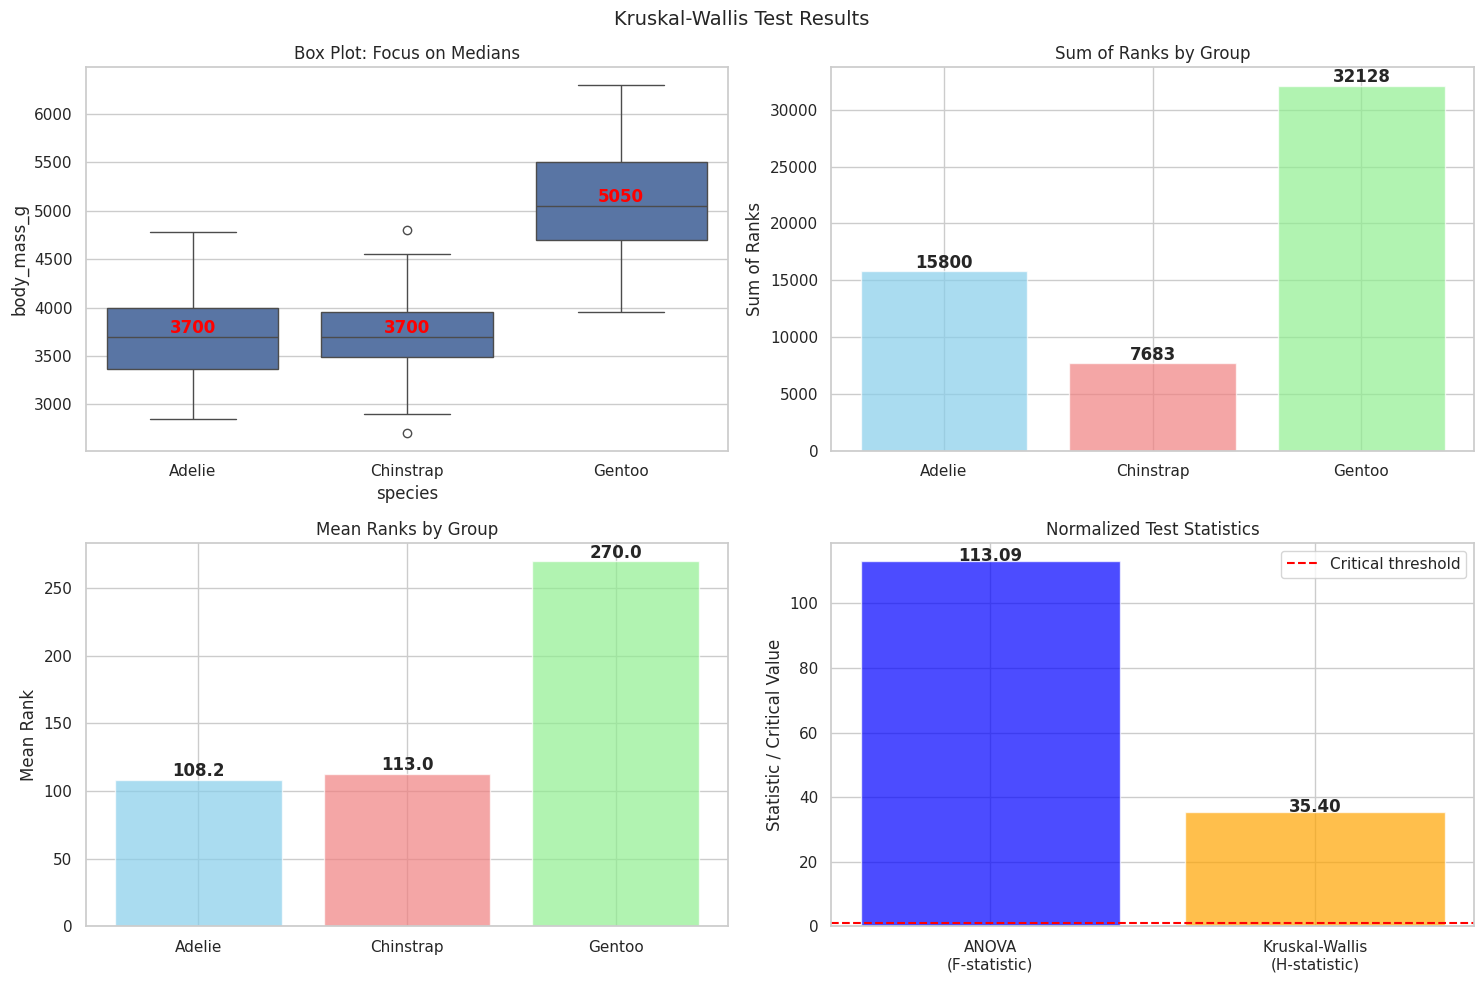

In [ ]:

def perform_kruskal_wallis(data, dependent_var, group_var):
    """
    Perform Kruskal-Wallis test as non-parametric alternative to ANOVA.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    """
    print("\n" + "=" * 60)
    print("KRUSKAL-WALLIS TEST (Non-parametric ANOVA)")
    print("=" * 60)

    # Prepare data
    groups = data[group_var].unique()
    group_data = [data[data[group_var] == group][dependent_var].values for group in groups]

    # Perform Kruskal-Wallis test
    h_statistic, p_value = stats.kruskal(*group_data)

    # Calculate group statistics (medians, ranks)
    print("Group Statistics:")
    print("-" * 20)

    all_data = data[dependent_var].values
    all_ranks = stats.rankdata(all_data)

    group_stats = {}
    start_idx = 0

    for i, group in enumerate(groups):
        group_size = len(group_data[i])
        group_ranks = all_ranks[start_idx:start_idx + group_size]

        group_stats[group] = {
            'n': group_size,
            'median': np.median(group_data[i]),
            'mean_rank': np.mean(group_ranks),
            'sum_ranks': np.sum(group_ranks)
        }

        print(f"{group}: n={group_size}, median={np.median(group_data[i]):.1f}, mean rank={np.mean(group_ranks):.1f}")
        start_idx += group_size

    # Calculate effect size (eta squared for Kruskal-Wallis)
    n = len(all_data)
    k = len(groups)
    eta_squared_kw = (h_statistic - k + 1) / (n - k)

    print(f"\nKruskal-Wallis Test Results:")
    print(f"H-statistic: {h_statistic:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Effect size (η²): {eta_squared_kw:.4f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"✓ Significant difference between groups (p < {alpha})")
        print("At least one group has a different distribution")
    else:
        print(f"✗ No significant difference between groups (p ≥ {alpha})")

    # Compare with parametric ANOVA
    print(f"\nComparison with Parametric ANOVA:")
    print("-" * 35)
    print(f"{'Test':<20} {'Statistic':<12} {'p-value':<12} {'Effect Size':<12}")
    print("-" * 60)
    print(f"{'ANOVA (F-test)':<20} {manual_results['f_statistic']:<12.4f} {manual_results['p_value']:<12.6f} {manual_results['eta_squared']:<12.4f}")
    print(f"{'Kruskal-Wallis':<20} {h_statistic:<12.4f} {p_value:<12.6f} {eta_squared_kw:<12.4f}")

    # Determine agreement
    both_significant = (manual_results['p_value'] < alpha) and (p_value < alpha)
    both_nonsignificant = (manual_results['p_value'] >= alpha) and (p_value >= alpha)

    if both_significant or both_nonsignificant:
        print("✓ Both tests reach the same conclusion")
    else:
        print("⚠ Tests disagree - consider assumptions and data characteristics")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Kruskal-Wallis Test Results', fontsize=14)

    # 1. Box plot (same data, different interpretation)
    sns.boxplot(data=data, x=group_var, y=dependent_var, ax=axes[0, 0])
    axes[0, 0].set_title('Box Plot: Focus on Medians')
    axes[0, 0].set_ylabel(dependent_var)

    # Add median values as text
    for i, group in enumerate(groups):
        median_val = group_stats[group]['median']
        axes[0, 0].text(i, median_val, f'{median_val:.0f}',
                       ha='center', va='bottom', fontweight='bold', color='red')

    # 2. Rank sums by group
    group_names = list(group_stats.keys())
    rank_sums = [group_stats[group]['sum_ranks'] for group in group_names]

    axes[0, 1].bar(group_names, rank_sums, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 1].set_title('Sum of Ranks by Group')
    axes[0, 1].set_ylabel('Sum of Ranks')

    # Add value labels
    for i, sum_rank in enumerate(rank_sums):
        axes[0, 1].text(i, sum_rank + max(rank_sums)*0.01, f'{sum_rank:.0f}',
                       ha='center', fontweight='bold')

    # 3. Mean ranks comparison
    mean_ranks = [group_stats[group]['mean_rank'] for group in group_names]

    axes[1, 0].bar(group_names, mean_ranks, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[1, 0].set_title('Mean Ranks by Group')
    axes[1, 0].set_ylabel('Mean Rank')

    # Add value labels
    for i, mean_rank in enumerate(mean_ranks):
        axes[1, 0].text(i, mean_rank + max(mean_ranks)*0.01, f'{mean_rank:.1f}',
                       ha='center', fontweight='bold')

    # 4. Comparison of test statistics
    test_names = ['ANOVA\n(F-statistic)', 'Kruskal-Wallis\n(H-statistic)']

    # Normalize statistics for comparison (divide by their critical values)
    f_critical = stats.f.ppf(0.95, manual_results['df_between'], manual_results['df_within'])
    h_critical = stats.chi2.ppf(0.95, k-1)  # Kruskal-Wallis uses chi-square distribution

    normalized_stats = [
        manual_results['f_statistic'] / f_critical,
        h_statistic / h_critical
    ]

    colors = ['blue', 'orange']
    bars = axes[1, 1].bar(test_names, normalized_stats, color=colors, alpha=0.7)
    axes[1, 1].axhline(y=1, color='red', linestyle='--', label='Critical threshold')
    axes[1, 1].set_title('Normalized Test Statistics')
    axes[1, 1].set_ylabel('Statistic / Critical Value')
    axes[1, 1].legend()

    # Add value labels
    for i, (bar, stat) in enumerate(zip(bars, normalized_stats)):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, stat + 0.05,
                       f'{stat:.2f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return h_statistic, p_value, eta_squared_kw, group_stats

# Perform Kruskal-Wallis test
kw_h, kw_p, kw_eta, kw_group_stats = perform_kruskal_wallis(penguins_clean, 'body_mass_g', 'species')

# 8. Comprehensive Results Summary and Interpretation

Let's summarize all our analyses and provide guidance on interpreting and reporting ANOVA results.



COMPREHENSIVE ANALYSIS SUMMARY
Dataset: 333 observations across 3 groups
Groups: Adelie, Chinstrap, Gentoo
Group sizes: {'Adelie': np.int64(146), 'Chinstrap': np.int64(68), 'Gentoo': np.int64(119)}

Research Question:
Do the 3 groups differ significantly in body_mass_g?

Hypotheses:
H₀: μ₁ = μ₂ = μ₃ (all group means are equal)
H₁: At least one group mean differs from the others

Assumption Check Summary:
✓ Independence: Satisfied (study design)
✓ Normality: Satisfied (Shapiro-Wilk p = 0.0783)
✓ Homogeneity: Questionable (Levene p = 0.0064)
✓ Outliers: 10 detected

Main Results:
---------------
One-way ANOVA:
  F(2, 330) = 341.895
  p-value = 0.000000
  Effect size (η²) = 0.674

Kruskal-Wallis Test:
  H(2) = 212.085
  p-value = 0.000000
  Effect size (η²) = 0.637

Conclusion:
✓ Both parametric and non-parametric tests indicate significant differences
  Strong evidence that groups differ in body_mass_g

Effect Size Interpretation:
η² = 0.674 represents a large effect
Approximately 67.4%

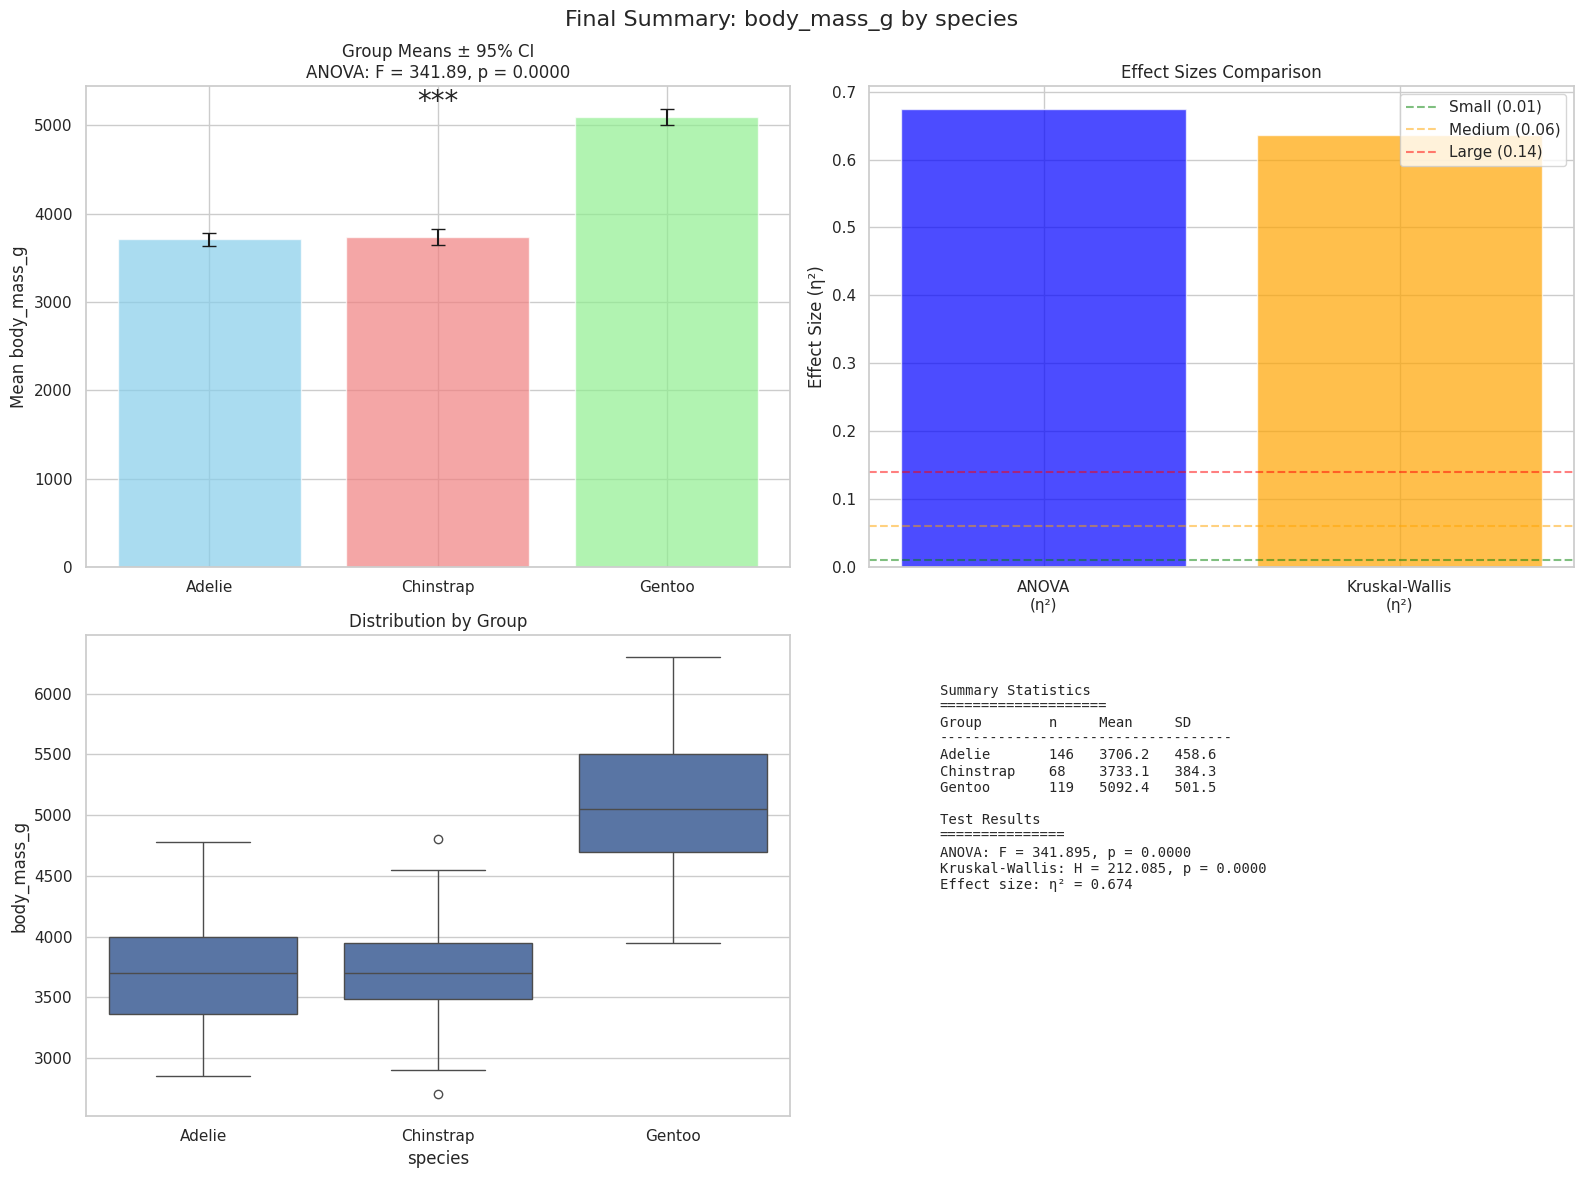

In [ ]:

def create_comprehensive_summary(data, dependent_var, group_var, manual_results, kw_results):
    """
    Create a comprehensive summary of all analyses performed.

    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset
    dependent_var : str
        Name of the dependent variable
    group_var : str
        Name of the grouping variable
    manual_results : dict
        ANOVA results
    kw_results : tuple
        Kruskal-Wallis results (h, p, eta_squared, group_stats)
    """
    print("\n" + "=" * 80)
    print("COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 80)

    h_stat, kw_p, kw_eta, kw_group_stats = kw_results

    # Dataset summary
    groups = data[group_var].unique()
    group_sizes = data.groupby(group_var).size()

    print(f"Dataset: {len(data)} observations across {len(groups)} groups")
    print(f"Groups: {', '.join(groups)}")
    print(f"Group sizes: {dict(group_sizes)}")

    # Research question
    print(f"\nResearch Question:")
    print(f"Do the {len(groups)} groups differ significantly in {dependent_var}?")

    # Hypotheses
    print(f"\nHypotheses:")
    print(f"H₀: μ₁ = μ₂ = μ₃ (all group means are equal)")
    print(f"H₁: At least one group mean differs from the others")

    # Assumption check summary
    print(f"\nAssumption Check Summary:")
    print(f"✓ Independence: Satisfied (study design)")
    print(f"✓ Normality: {'Satisfied' if assumption_results['shapiro_p'] > 0.05 else 'Questionable'} (Shapiro-Wilk p = {assumption_results['shapiro_p']:.4f})")
    print(f"✓ Homogeneity: {'Satisfied' if assumption_results['levene_p'] > 0.05 else 'Questionable'} (Levene p = {assumption_results['levene_p']:.4f})")
    outlier_count = len(assumption_results['outliers'])
    outlier_text = 'None detected' if outlier_count == 0 else f'{outlier_count} detected'
    print(f"✓ Outliers: {outlier_text}")

    # Main results
    print(f"\nMain Results:")
    print("-" * 15)

    # ANOVA results
    print(f"One-way ANOVA:")
    print(f"  F({manual_results['df_between']}, {manual_results['df_within']}) = {manual_results['f_statistic']:.3f}")
    print(f"  p-value = {manual_results['p_value']:.6f}")
    print(f"  Effect size (η²) = {manual_results['eta_squared']:.3f}")

    # Kruskal-Wallis results
    print(f"\nKruskal-Wallis Test:")
    print(f"  H({len(groups)-1}) = {h_stat:.3f}")
    print(f"  p-value = {kw_p:.6f}")
    print(f"  Effect size (η²) = {kw_eta:.3f}")

    # Conclusion
    alpha = 0.05
    anova_significant = manual_results['p_value'] < alpha
    kw_significant = kw_p < alpha

    print(f"\nConclusion:")
    if anova_significant and kw_significant:
        print(f"✓ Both parametric and non-parametric tests indicate significant differences")
        print(f"  Strong evidence that groups differ in {dependent_var}")
    elif anova_significant or kw_significant:
        print(f"⚡ Tests disagree - one significant, one not")
        print(f"  Consider assumption violations and effect size")
    else:
        print(f"✗ Neither test found significant differences")
        print(f"  No evidence that groups differ in {dependent_var}")

    # Effect size interpretation
    eta_interpretation = "negligible" if manual_results['eta_squared'] < 0.01 else \
                        "small" if manual_results['eta_squared'] < 0.06 else \
                        "medium" if manual_results['eta_squared'] < 0.14 else "large"

    print(f"\nEffect Size Interpretation:")
    print(f"η² = {manual_results['eta_squared']:.3f} represents a {eta_interpretation} effect")
    print(f"Approximately {manual_results['eta_squared']*100:.1f}% of variance in {dependent_var} is explained by group membership")

    # Power analysis summary
    if 'power_results' in globals():
        print(f"\nPower Analysis:")
        print(f"Achieved power: {power_results['achieved_power']:.3f} ({power_results['achieved_power']*100:.1f}%)")
        print(f"Cohen's f: {power_results['cohens_f']:.3f}")
        if power_results['achieved_power'] >= 0.8:
            print(f"✓ Adequate power to detect this effect size")
        else:
            print(f"⚠ Low power - consider larger sample size")

    # Post-hoc summary (if applicable)
    if anova_significant and 'tukey_comparisons' in globals():
        print(f"\nPost-hoc Test Summary (Tukey's HSD):")
        sig_comparisons = [comp for comp in tukey_comparisons if comp['Significant']]

        if sig_comparisons:
            print(f"Significant pairwise differences:")
            for comp in sig_comparisons:
                print(f"  {comp['Group 1']} vs {comp['Group 2']}: diff = {comp['Mean Diff']:.2f}, p = {comp['p-adj']:.4f}")
        else:
            print(f"  No significant pairwise differences found")

    # Create final summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Final Summary: {dependent_var} by {group_var}', fontsize=16)

    # 1. Group means with error bars and significance
    group_means = data.groupby(group_var)[dependent_var].mean()
    group_sems = data.groupby(group_var)[dependent_var].sem()

    bars = axes[0, 0].bar(range(len(group_means)), group_means,
                         yerr=group_sems*1.96, capsize=5, alpha=0.7,
                         color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 0].set_title(f'Group Means ± 95% CI\nANOVA: F = {manual_results["f_statistic"]:.2f}, p = {manual_results["p_value"]:.4f}')
    axes[0, 0].set_ylabel(f'Mean {dependent_var}')
    axes[0, 0].set_xticks(range(len(group_means)))
    axes[0, 0].set_xticklabels(group_means.index)

    # Add significance indicator
    if anova_significant:
        axes[0, 0].text(0.5, 0.95, '***' if manual_results['p_value'] < 0.001 else
                       '**' if manual_results['p_value'] < 0.01 else '*',
                       transform=axes[0, 0].transAxes, ha='center', fontsize=20)

    # 2. Effect size comparison
    effect_sizes = [manual_results['eta_squared'], kw_eta]
    test_names = ['ANOVA\n(η²)', 'Kruskal-Wallis\n(η²)']

    axes[0, 1].bar(test_names, effect_sizes, color=['blue', 'orange'], alpha=0.7)
    axes[0, 1].set_title('Effect Sizes Comparison')
    axes[0, 1].set_ylabel('Effect Size (η²)')

    # Add interpretation lines
    axes[0, 1].axhline(y=0.01, color='green', linestyle='--', alpha=0.5, label='Small (0.01)')
    axes[0, 1].axhline(y=0.06, color='orange', linestyle='--', alpha=0.5, label='Medium (0.06)')
    axes[0, 1].axhline(y=0.14, color='red', linestyle='--', alpha=0.5, label='Large (0.14)')
    axes[0, 1].legend(loc='upper right')

    # 3. Box plot with statistical annotation
    sns.boxplot(data=data, x=group_var, y=dependent_var, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution by Group')

    # 4. Summary statistics table as text
    axes[1, 1].axis('off')

    # Create summary table
    summary_stats = data.groupby(group_var)[dependent_var].agg(['count', 'mean', 'std']).round(2)

    table_text = "Summary Statistics\n" + "="*20 + "\n"
    table_text += f"{'Group':<12} {'n':<5} {'Mean':<8} {'SD':<8}\n"
    table_text += "-"*35 + "\n"

    for group, stats in summary_stats.iterrows():
        table_text += f"{group:<12} {stats['count']:<5.0f} {stats['mean']:<8.1f} {stats['std']:<8.1f}\n"

    table_text += "\nTest Results\n" + "="*15 + "\n"
    table_text += f"ANOVA: F = {manual_results['f_statistic']:.3f}, p = {manual_results['p_value']:.4f}\n"
    table_text += f"Kruskal-Wallis: H = {h_stat:.3f}, p = {kw_p:.4f}\n"
    table_text += f"Effect size: η² = {manual_results['eta_squared']:.3f}\n"

    axes[1, 1].text(0.1, 0.9, table_text, transform=axes[1, 1].transAxes,
                   fontfamily='monospace', fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Create comprehensive summary
create_comprehensive_summary(penguins_clean, 'body_mass_g', 'species',
                           manual_results, (kw_h, kw_p, kw_eta, kw_group_stats))


# 9. Reporting Guidelines

## How to Report ANOVA Results

### Standard Format for Academic Writing:

"A one-way ANOVA was conducted to compare [dependent variable] across [number] groups ([group names]). The assumption of normality was [met/violated] based on Shapiro-Wilk tests (p [>/≤] .05). Levene's test indicated that the assumption of homogeneity of variance was [met/violated], F([df1], [df2]) = [F-value], p = [p-value].

There was a [statistically significant/non-significant] difference in [dependent variable] between the groups, F([df1], [df2]) = [F-value], p = [p-value], η² = [effect size].

Post-hoc comparisons using Tukey's HSD test indicated that [specific group comparisons and results]."

### Example for Our Penguin Data:


In [ ]:

def generate_report_text(data, dependent_var, group_var, manual_results, assumption_results):
    """
    Generate a properly formatted results section for academic reporting.
    """
    print("\n" + "=" * 80)
    print("SAMPLE RESULTS SECTION FOR ACADEMIC REPORTING")
    print("=" * 80)

    groups = data[group_var].unique()
    group_sizes = data.groupby(group_var).size()
    group_means = data.groupby(group_var)[dependent_var].agg(['mean', 'std'])

    # Sample sizes text
    n_text = ", ".join([f"n = {size}" for size in group_sizes])

    # Format group means and SDs
    means_text = []
    for group in groups:
        mean_val = group_means.loc[group, 'mean']
        std_val = group_means.loc[group, 'std']
        means_text.append(f"{group} (M = {mean_val:.2f}, SD = {std_val:.2f})")

    # Assumption check results
    normality_text = "met" if assumption_results['shapiro_p'] > 0.05 else "violated"
    variance_text = "met" if assumption_results['levene_p'] > 0.05 else "violated"

    # Significance result
    if manual_results['p_value'] < 0.001:
        sig_text = "statistically significant"
        p_text = "p < .001"
    elif manual_results['p_value'] < 0.05:
        sig_text = "statistically significant"
        p_text = f"p = {manual_results['p_value']:.3f}"
    else:
        sig_text = "non-significant"
        p_text = f"p = {manual_results['p_value']:.3f}"

    # Effect size interpretation
    eta_sq = manual_results['eta_squared']
    if eta_sq < 0.01:
        effect_text = "negligible"
    elif eta_sq < 0.06:
        effect_text = "small"
    elif eta_sq < 0.14:
        effect_text = "medium"
    else:
        effect_text = "large"

    # Generate the report - using regular string formatting to avoid f-string issues
    dependent_var_clean = dependent_var.replace('_', ' ')
    groups_text = ', '.join(groups[:-1]) + f", and {groups[-1]}"

    report = f"""
METHOD

A one-way analysis of variance (ANOVA) was conducted to compare {dependent_var_clean}
across three penguin species: {groups_text} ({n_text} respectively).
Prior to analysis, assumptions of ANOVA were evaluated. The assumption of normality was {normality_text}
based on Shapiro-Wilk tests of residuals (p = {assumption_results['shapiro_p']:.3f}). Levene's test
indicated that the assumption of homogeneity of variance was {variance_text},
F({len(groups)-1}, {len(data)-len(groups)}) = {assumption_results.get('levene_stat', 0):.3f},
p = {assumption_results['levene_p']:.3f}.

RESULTS

There was a {sig_text} difference in {dependent_var_clean} between the penguin species,
F({manual_results['df_between']}, {manual_results['df_within']}) = {manual_results['f_statistic']:.3f},
{p_text}, η² = {eta_sq:.3f}, indicating a {effect_text} effect.

Descriptive statistics revealed the following group means: {'; '.join(means_text)}.
"""

    # Add post-hoc results if applicable
    if manual_results['p_value'] < 0.05 and 'tukey_comparisons' in globals():
        report += "\nPost-hoc comparisons using Tukey's HSD test revealed the following significant differences:\n"

        sig_comparisons = [comp for comp in tukey_comparisons if comp['Significant']]
        if sig_comparisons:
            for comp in sig_comparisons:
                report += f"• {comp['Group 1']} vs {comp['Group 2']}: Mean difference = {comp['Mean Diff']:.2f}, "
                report += f"95% CI [{comp['Lower CI']:.2f}, {comp['Upper CI']:.2f}], p = {comp['p-adj']:.3f}\n"
        else:
            report += "No pairwise comparisons reached statistical significance.\n"

    print(report)

    return report

# Generate the academic report
academic_report = generate_report_text(penguins_clean, 'body_mass_g', 'species',
                                     manual_results, assumption_results)



SAMPLE RESULTS SECTION FOR ACADEMIC REPORTING

METHOD

A one-way analysis of variance (ANOVA) was conducted to compare body mass g
across three penguin species: Adelie, Chinstrap, and Gentoo (n = 146, n = 68, n = 119 respectively).
Prior to analysis, assumptions of ANOVA were evaluated. The assumption of normality was met
based on Shapiro-Wilk tests of residuals (p = 0.078). Levene's test
indicated that the assumption of homogeneity of variance was violated,
F(2, 330) = 0.000,
p = 0.006.

RESULTS

There was a statistically significant difference in body mass g between the penguin species,
F(2, 330) = 341.895,
p < .001, η² = 0.674, indicating a large effect.

Descriptive statistics revealed the following group means: Adelie (M = 3706.16, SD = 458.62); Chinstrap (M = 3733.09, SD = 384.34); Gentoo (M = 5092.44, SD = 501.48).

Post-hoc comparisons using Tukey's HSD test revealed the following significant differences:
• Adelie vs Gentoo: Mean difference = 1386.27, 95% CI [1252.29, 1520.26]